In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
from keras.layers import Embedding
import pickle as pkl

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd /content/drive/MyDrive/Colab Notebooks/new_project

/content/drive/MyDrive/Colab Notebooks/new_project


In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv("imdb.csv", usecols=["review", "sentiment"], encoding='latin-1')
## 1 - positive, 0 - negative
df.sentiment = (df.sentiment == "positive").astype("int")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [10]:
# Importing libraries
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# Our dictionary will contain only of the top 7000 words appearing most frequently
top_words = 7000
# Now we split our data-set into training and test data
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words,maxlen=450)
# Looking at the nature of training data
print(X_train[0])
print(y_train[0])
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1
Shape of training data: 
(22284,)
(22284,)
Shape of test data

## split

In [ ]:
val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)


def train_val_test_split(df=None, train_percent=0.7, test_percent=0.15, val_percent=0.15):
  df = df.sample(frac=1)
  train_df = df[: int(len(df)*train_percent)]
  test_df = df[int(len(df)*train_percent)+1 : int(len(df)*(train_percent+test_percent))]
  val_df = df[int(len(df)*(train_percent + test_percent))+1 : ]
  return train_df, test_df, val_df

train_df, test_df, val_df = train_val_test_split(df, 0.7, 0.15, 0.15)
train_labels, train_texts = train_df.values[:,1], train_df.values[:,0]
val_labels, val_texts = val_df.values[:,1], val_df.values[:,0]
test_labels, test_texts = test_df.values[:,1], test_df.values[:,0]
print(len(train_df), len(test_df), len(val_df))
print(len(train_texts), len(train_labels), len(val_df))

In [ ]:
train_texts[0]

In [ ]:
train_labels

## Tokenize text of the training data with keras text preprocessing functions

In [ ]:
#english

from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

def process_tokens(text):
    """
    function to process tokens, replace any unwanted chars
    """
    preprocessed_text = text.lower().replace(",", "").replace(".", "").replace(":", "").replace(")", "").replace("-", "").replace("(", "")
    preprocessed_text = ''.join([i for i in preprocessed_text if not preprocessed_text.isdigit()])
    return preprocessed_text

def preprocessing(data):
    """
    preprocessing data to list of tokens
    """
    nlp = English()
    tokenizer = Tokenizer(nlp.vocab)
    preprocessed_data = []
    for sentence in data:
        sentence = process_tokens(sentence)
        tokens = tokenizer(sentence)
        tlist = []
        for token in tokens:
            tlist.append(str(token))
        preprocessed_data.append(tlist)
    return preprocessed_data

train_data = preprocessing(train_texts)
val_data = preprocessing(val_texts)
test_data = preprocessing(test_texts)




In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
NUM_WORDS=20000
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)

In [ ]:
tokenizer.fit_on_texts(train_data)
sequences_train = tokenizer.texts_to_sequences(train_data)
sequences_valid=tokenizer.texts_to_sequences(val_data)
sequences_test=tokenizer.texts_to_sequences(test_data)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 208097 unique tokens.


In [ ]:
len(word_index)

208097

In [ ]:
#decode y

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

y_train = y_train.astype('int')
y_val = y_val.astype('int')
y_test = y_test.astype('int')

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_val = to_categorical(y_val, 2)

In [ ]:
print(f'X_train.shape: {len(sequences_train)}, y_train.shape: {y_train.shape}')

X_train.shape: 35000, y_train.shape: (35000, 2)


### pad sequence

In [ ]:
X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid,maxlen=X_train.shape[1])
X_test=pad_sequences(sequences_test,maxlen=X_train.shape[1])

In [ ]:

print('Shape of X train and X validation tensor:', X_train.shape,X_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)

Shape of X train and X validation tensor: (35000, 1936) (7499, 1936)
Shape of label train and validation tensor: (35000, 2) (7499, 2)


## use word2vec as embedding layer

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors


EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)


In [ ]:


vocabulary_size

20000

In [ ]:
#don't run
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        print(f'word {word} not in w2v')
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

word and not in w2v
word a not in w2v
word of not in w2v
word to not in w2v
word /><br not in w2v
word   not in w2v
word />the not in w2v
word <br not in w2v
word i'm not in w2v
word />i not in w2v
word i've not in w2v
word "the not in w2v
word />this not in w2v
word 10 not in w2v
word â not in w2v
word i'd not in w2v
word />in not in w2v
word />it not in w2v
word film's not in w2v
word />if not in w2v
word it<br not in w2v
word />but not in w2v
word />there not in w2v
word i'll not in w2v
word movie<br not in w2v
word film<br not in w2v
word />and not in w2v
word ! not in w2v
word />a not in w2v
word />as not in w2v
word />it's not in w2v
word 20 not in w2v
word 'the not in w2v
word />so not in w2v
word />what not in w2v
word it! not in w2v
word "i not in w2v
word   not in w2v
word humour not in w2v
word 80's not in w2v
word 15 not in w2v
word 30 not in w2v
word />all not in w2v
word />my not in w2v
word movie's not in w2v
word />one not in w2v
word " not in w2v
word ? not in w2v
wo

In [ ]:
#dump to pkl
with open('em_w2v_train.pkl', 'wb') as handle:
    pkl.dump(embedding_matrix, handle)

In [ ]:
# load if saevd
with open('em_w2v_train.pkl', 'rb') as handle:
    embedding_matrix=pkl.load(handle)

In [ ]:
from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)  #-------unsure

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
         0.04760742, -0.06884766],
       [-0.91204109,  0.88575532,  0.0025902 , ..., -0.50070606,
        -0.4411896 , -0.5499527 ],
       ...,
       [ 0.08837891,  0.10644531,  0.09912109, ..., -0.15820312,
        -0.04760742, -0.07226562],
       [ 0.01281738,  0.0078125 , -0.02758789, ..., -0.11328125,
         0.05151367,  0.15820312],
       [ 0.01275635, -0.12988281, -0.10058594, ..., -0.01928711,
        -0.18261719,  0.12695312]])

In [ ]:
embedding_matrix.shape

(20000, 300)

In [11]:
# Padding the data samples to a maximum review length in word

In [13]:

X_train = sequence.pad_sequences(X_train, maxlen=450)
X_test = sequence.pad_sequences(X_test, maxlen=450)


# hyperband to find hyperparams

In [15]:
pip install -U "ray[tune]"==1.11.0


     |████████████████████████████████| 52.7 MB 154 kB/s 
     |████████████████████████████████| 241 kB 32.0 MB/s 
     |████████████████████████████████| 4.1 MB 33.4 MB/s 
     |████████████████████████████████| 125 kB 41.1 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers

#import ray
from ray import tune
from ray.tune.integration.keras import TuneReportCallback

# define model

## embedding layer

In [32]:
from keras.layers import Embedding
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)

embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM)

In [33]:
from math import *

In [34]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Reshape,Conv2D, MaxPooling2D, Flatten, Input, concatenate, Add, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from keras import regularizers

In [44]:
def Conv1(config):
  sequence_length = X_train.shape[1]

  EMBEDDING_DIM=32

  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer(inputs)
  
  reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

  conv_0 = Conv2D(config['num_filters'], (config["conv_filters_1"], EMBEDDING_DIM),activation=config['act'])(reshape)
  conv_1 = Conv2D(config['num_filters'], (config["conv_filters_2"], EMBEDDING_DIM),activation=config['act'])(reshape)
  conv_2 = Conv2D(config['num_filters'], (config["conv_filters_3"], EMBEDDING_DIM),activation=config['act'])(reshape)

  maxpool_0 = MaxPooling2D((sequence_length - config["conv_filters_1"] + 1, 1), strides=(1,1))(conv_0)
  maxpool_1 = MaxPooling2D((sequence_length - config["conv_filters_2"] + 1, 1), strides=(1,1))(conv_1)
  maxpool_2 = MaxPooling2D((sequence_length - config["conv_filters_3"] + 1, 1), strides=(1,1))(conv_2)

  merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
  flatten = Flatten()(merged_tensor)
  #reshape = Reshape((3*config['num_filters'],))(flatten)

  #penultimate layer
  dense_1 = Dense(128, activation=config['act'], kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(config['reg']))(flatten)
  dropout = Dropout(config['dropout'])(flatten)
  
  output = Dense(units=1, activation='softmax')(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  return model


In [ ]:
def Conv1(config):
  sequence_length = X_train.shape[1]

  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer(inputs)
  
  reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

  conv_0 = Conv2D(100, (2, EMBEDDING_DIM),activation=config['act'])(reshape)
  conv_1 = Conv2D(100, (3, EMBEDDING_DIM),activation=config['act'])(reshape)
  conv_2 = Conv2D(100, (4, EMBEDDING_DIM),activation=config['act'])(reshape)

  maxpool_0 = MaxPooling2D((sequence_length - 2 + 1, 1), strides=(1,1))(conv_0)
  maxpool_1 = MaxPooling2D((sequence_length - 3 + 1, 1), strides=(1,1))(conv_1)
  maxpool_2 = MaxPooling2D((sequence_length - 4 + 1, 1), strides=(1,1))(conv_2)

  merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
  flatten = Flatten()(merged_tensor)
  #reshape = Reshape((3*config['num_filters'],))(flatten)

  #penultimate layer
  dense_1 = Dense(128, activation=config['act'], kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(config['reg']))(flatten)
  dropout = Dropout(config['dropout'])(flatten)
  
  output = Dense(units=2, activation='softmax')(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  return model


In [47]:
def tune_model(config):
  model=Conv1(config)
  model.compile(
          loss="binary_crossentropy",
          optimizer=tf.keras.optimizers.Adam(
              lr=config["lr"]),
          metrics=["accuracy"])

  model.fit(
      X_train,
      y_train,
      batch_size=round(config['batch_size']),
      epochs=10,
      verbose=1,
      validation_data=(X_test, y_test),
      callbacks=[TuneReportCallback({
          "mean_accuracy": "accuracy"
      })])

## hyperband

In [22]:
from ray.tune.schedulers import HyperBandScheduler

In [46]:
hyperband_scheduler = HyperBandScheduler(
    time_attr='training_iteration', #budget
    metric='mean_accuracy',
    mode='max',
    max_t=10,
    reduction_factor=3) #after each run, discard these many models

In [ ]:
fimport grpc

In [ ]:
# create the gRPC stub
options = [('grpc.max_message_length', 100 * 1024 * 1024)]
channel = grpc.insecure_channel(server_url, options = options)
stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)

NameError: ignored

In [48]:
analysis = tune.run(
        tune_model,
        name="exp",
        resources_per_trial={
            "gpu": 1,
            #"cpu": 4
        },
        config={
          "num_filters": tune.grid_search([50,100]),
          "conv_filters_1": tune.grid_search([3,4,5]),
          "conv_filters_2": tune.grid_search([3,4,5]),
          "conv_filters_3": tune.grid_search([3,4,5]),
          'dropout':tune.uniform(0, 1),
          'lr':tune.grid_search([0.1,0.01]),
          'reg':tune.uniform(0, 1),
          'batch_size':tune.grid_search([64,128]),
          'act':tune.grid_search(['relu','tanh'])
        },
        scheduler=hyperband_scheduler)

2022-05-13 17:45:26,460	WARNING worker.py:1326 -- Warning: The actor ImplicitFunc is very large (77 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-05-13 17:45:26,710	WARNING util.py:164 -- The `start_trial` operation took 1.455 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535


(tune_model pid=2682) 2022-05-13 17:45:32.064570: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(tune_model pid=2682) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(tune_model pid=2682)   super(Adam, self).__init__(name, **kwargs)
2022-05-13 17:45:32,912	WARNING util.py:164 -- The `start_trial` operation took 0.950 s, which may be a performance bottleneck.


(tune_model pid=2682) Epoch 1/10


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535


2022-05-13 17:45:34,493	WARNING util.py:164 -- The `start_trial` operation took 1.451 s, which may be a performance bottleneck.
2022-05-13 17:45:35,649	WARNING util.py:164 -- The `start_trial` operation took 1.050 s, which may be a performance bottleneck.
2022-05-13 17:45:36,435	WARNING util.py:164 -- The `start_trial` operation took 0.676 s, which may be a performance bottleneck.
2022-05-13 17:45:37,188	WARNING util.py:164 -- The `start_trial` operation took 0.643 s, which may be a performance bottleneck.
2022-05-13 17:45:37,944	WARNING util.py:164 -- The `start_trial` operation took 0.632 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535


2022-05-13 17:45:38,676	WARNING util.py:164 -- The `start_trial` operation took 0.618 s, which may be a performance bottleneck.
2022-05-13 17:45:39,430	WARNING util.py:164 -- The `start_trial` operation took 0.650 s, which may be a performance bottleneck.
2022-05-13 17:45:40,175	WARNING util.py:164 -- The `start_trial` operation took 0.630 s, which may be a performance bottleneck.
2022-05-13 17:45:40,911	WARNING util.py:164 -- The `start_trial` operation took 0.632 s, which may be a performance bottleneck.
2022-05-13 17:45:41,640	WARNING util.py:164 -- The `start_trial` operation took 0.624 s, which may be a performance bottleneck.
2022-05-13 17:45:42,396	WARNING util.py:164 -- The `start_trial` operation took 0.650 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535


2022-05-13 17:45:43,974	WARNING util.py:164 -- The `start_trial` operation took 0.565 s, which may be a performance bottleneck.
2022-05-13 17:45:45,677	WARNING util.py:164 -- The `start_trial` operation took 0.696 s, which may be a performance bottleneck.
2022-05-13 17:45:47,313	WARNING util.py:164 -- The `start_trial` operation took 0.633 s, which may be a performance bottleneck.
2022-05-13 17:45:48,954	WARNING util.py:164 -- The `start_trial` operation took 0.616 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535


  7/349 [..............................] - ETA: 14s - loss: 1.0812 - accuracy: 0.4665


2022-05-13 17:45:50,781	WARNING util.py:164 -- The `start_trial` operation took 0.802 s, which may be a performance bottleneck.


 57/349 [===>..........................] - ETA: 9s - loss: 1.0518 - accuracy: 0.4948 


2022-05-13 17:45:52,532	WARNING util.py:164 -- The `start_trial` operation took 0.744 s, which may be a performance bottleneck.


114/349 [========>.....................] - ETA: 7s - loss: 1.5511 - accuracy: 0.5003


2022-05-13 17:45:54,275	WARNING util.py:164 -- The `start_trial` operation took 0.730 s, which may be a performance bottleneck.


156/349 [============>.................] - ETA: 6s - loss: 2.0184 - accuracy: 0.4938


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535


168/349 [=============>................] - ETA: 6s - loss: 2.1321 - accuracy: 0.4935


2022-05-13 17:45:56,073	WARNING util.py:164 -- The `start_trial` operation took 0.759 s, which may be a performance bottleneck.


222/349 [==================>...........] - ETA: 4s - loss: 2.6503 - accuracy: 0.4926


2022-05-13 17:45:57,856	WARNING util.py:164 -- The `start_trial` operation took 0.764 s, which may be a performance bottleneck.


276/349 [======================>.......] - ETA: 2s - loss: 2.7990 - accuracy: 0.4953


2022-05-13 17:45:59,673	WARNING util.py:164 -- The `start_trial` operation took 0.793 s, which may be a performance bottleneck.


317/349 [==========================>...] - ETA: 1s - loss: 2.7907 - accuracy: 0.4959


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535


331/349 [===========================>..] - ETA: 0s - loss: 2.7753 - accuracy: 0.4964


2022-05-13 17:46:01,482	WARNING util.py:164 -- The `start_trial` operation took 0.774 s, which may be a performance bottleneck.


349/349 [==============================] - ETA: 0s - loss: 2.7553 - accuracy: 0.4955


2022-05-13 17:46:03,212	WARNING util.py:164 -- The `start_trial` operation took 0.712 s, which may be a performance bottleneck.
2022-05-13 17:46:04,937	WARNING util.py:164 -- The `start_trial` operation took 0.722 s, which may be a performance bottleneck.


Result for tune_model_7002d_00000:
  date: 2022-05-13_17-46-05
  done: false
  experiment_id: 4bfde50e7c374988b0783de0d84da261
  hostname: 01a6007f645e
  iterations_since_restore: 1
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 2682
  time_since_restore: 34.55798006057739
  time_this_iter_s: 34.55798006057739
  time_total_s: 34.55798006057739
  timestamp: 1652463965
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7002d_00000
  
349/349 [==============================] - 33s 44ms/step - loss: 2.7553 - accuracy: 0.4955 - val_loss: 1.7040 - val_accuracy: 0.4969
(tune_model pid=2682) Epoch 2/10
  9/349 [..............................] - ETA: 11s - loss: 1.8907 - accuracy: 0.4670


2022-05-13 17:46:06,228	WARNING util.py:164 -- The `start_trial` operation took 0.762 s, which may be a performance bottleneck.


 51/349 [===>..........................] - ETA: 9s - loss: 1.7918 - accuracy: 0.5077


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,1,34.558
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


 65/349 [====>.........................] - ETA: 9s - loss: 1.7451 - accuracy: 0.5022


2022-05-13 17:46:08,030	WARNING util.py:164 -- The `start_trial` operation took 0.769 s, which may be a performance bottleneck.


121/349 [=========>....................] - ETA: 7s - loss: 1.7345 - accuracy: 0.4991


2022-05-13 17:46:09,871	WARNING util.py:164 -- The `start_trial` operation took 0.793 s, which may be a performance bottleneck.


173/349 [=============>................] - ETA: 5s - loss: 1.5675 - accuracy: 0.4974


2022-05-13 17:46:11,631	WARNING util.py:164 -- The `start_trial` operation took 0.751 s, which may be a performance bottleneck.


215/349 [=================>............] - ETA: 4s - loss: 1.5856 - accuracy: 0.4971


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,1,34.558
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


231/349 [==================>...........] - ETA: 3s - loss: 1.5635 - accuracy: 0.4950


2022-05-13 17:46:13,440	WARNING util.py:164 -- The `start_trial` operation took 0.749 s, which may be a performance bottleneck.


283/349 [=======================>......] - ETA: 2s - loss: 1.5041 - accuracy: 0.4959


2022-05-13 17:46:15,188	WARNING util.py:164 -- The `start_trial` operation took 0.744 s, which may be a performance bottleneck.


338/349 [============================>.] - ETA: 0s - loss: 1.4345 - accuracy: 0.4962


2022-05-13 17:46:16,964	WARNING util.py:164 -- The `start_trial` operation took 0.772 s, which may be a performance bottleneck.


348/349 [============================>.] - ETA: 0s - loss: 1.4219 - accuracy: 0.4954


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,1,34.558
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


2022-05-13 17:46:18,721	WARNING util.py:164 -- The `start_trial` operation took 0.738 s, which may be a performance bottleneck.
2022-05-13 17:46:20,492	WARNING util.py:164 -- The `start_trial` operation took 0.741 s, which may be a performance bottleneck.
2022-05-13 17:46:22,057	WARNING util.py:164 -- The `start_trial` operation took 0.561 s, which may be a performance bottleneck.


Result for tune_model_7002d_00000:
  date: 2022-05-13_17-46-22
  done: false
  experiment_id: 4bfde50e7c374988b0783de0d84da261
  hostname: 01a6007f645e
  iterations_since_restore: 2
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 2682
  time_since_restore: 51.195191860198975
  time_this_iter_s: 16.637211799621582
  time_total_s: 51.195191860198975
  timestamp: 1652463982
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 7002d_00000
  
349/349 [==============================] - 17s 48ms/step - loss: 1.4214 - accuracy: 0.4955 - val_loss: 1.3734 - val_accuracy: 0.4969
(tune_model pid=2682) Epoch 3/10
 11/349 [..............................] - ETA: 12s - loss: 1.3450 - accuracy: 0.4886


2022-05-13 17:46:22,900	WARNING util.py:164 -- The `start_trial` operation took 0.800 s, which may be a performance bottleneck.


 49/349 [===>..........................] - ETA: 10s - loss: 1.2513 - accuracy: 0.4911


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,2,51.1952
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


 64/349 [====>.........................] - ETA: 9s - loss: 1.4342 - accuracy: 0.4954

2022-05-13 17:46:24,714	WARNING util.py:164 -- The `start_trial` operation took 0.771 s, which may be a performance bottleneck.



118/349 [=========>....................] - ETA: 7s - loss: 1.4540 - accuracy: 0.4932


2022-05-13 17:46:26,445	WARNING util.py:164 -- The `start_trial` operation took 0.724 s, which may be a performance bottleneck.


172/349 [=============>................] - ETA: 5s - loss: 1.3703 - accuracy: 0.4925


2022-05-13 17:46:28,243	WARNING util.py:164 -- The `start_trial` operation took 0.793 s, which may be a performance bottleneck.


214/349 [=================>............] - ETA: 4s - loss: 1.3158 - accuracy: 0.4946


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,2,51.1952
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


228/349 [==================>...........] - ETA: 4s - loss: 1.2870 - accuracy: 0.4945


2022-05-13 17:46:30,129	WARNING util.py:164 -- The `start_trial` operation took 0.856 s, which may be a performance bottleneck.


282/349 [=======================>......] - ETA: 2s - loss: 1.2763 - accuracy: 0.4938


2022-05-13 17:46:31,893	WARNING util.py:164 -- The `start_trial` operation took 0.732 s, which may be a performance bottleneck.


337/349 [===========================>..] - ETA: 0s - loss: 1.2435 - accuracy: 0.4949


2022-05-13 17:46:33,685	WARNING util.py:164 -- The `start_trial` operation took 0.776 s, which may be a performance bottleneck.


348/349 [============================>.] - ETA: 0s - loss: 1.2703 - accuracy: 0.4954


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,2,51.1952
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


2022-05-13 17:46:35,524	WARNING util.py:164 -- The `start_trial` operation took 0.806 s, which may be a performance bottleneck.
2022-05-13 17:46:37,280	WARNING util.py:164 -- The `start_trial` operation took 0.739 s, which may be a performance bottleneck.


Result for tune_model_7002d_00000:
  date: 2022-05-13_17-46-37
  done: false
  experiment_id: 4bfde50e7c374988b0783de0d84da261
  hostname: 01a6007f645e
  iterations_since_restore: 3
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 2682
  time_since_restore: 66.31782150268555
  time_this_iter_s: 15.122629642486572
  time_total_s: 66.31782150268555
  timestamp: 1652463997
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 7002d_00000
  
349/349 [==============================] - 15s 44ms/step - loss: 1.2700 - accuracy: 0.4955 - val_loss: 2.2270 - val_accuracy: 0.4969
(tune_model pid=2682) Epoch 4/10
  9/349 [..............................] - ETA: 11s - loss: 1.6212 - accuracy: 0.5226


2022-05-13 17:46:38,087	WARNING util.py:164 -- The `start_trial` operation took 0.787 s, which may be a performance bottleneck.


 63/349 [====>.........................] - ETA: 9s - loss: 2.4419 - accuracy: 0.4970


2022-05-13 17:46:39,820	WARNING util.py:164 -- The `start_trial` operation took 0.728 s, which may be a performance bottleneck.


103/349 [=======>......................] - ETA: 8s - loss: 2.2889 - accuracy: 0.4995


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,3,66.3178
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


120/349 [=========>....................] - ETA: 8s - loss: 2.1522 - accuracy: 0.4971


2022-05-13 17:46:41,898	WARNING util.py:164 -- The `start_trial` operation took 0.763 s, which may be a performance bottleneck.


174/349 [=============>................] - ETA: 5s - loss: 1.8676 - accuracy: 0.4980


2022-05-13 17:46:43,675	WARNING util.py:164 -- The `start_trial` operation took 0.755 s, which may be a performance bottleneck.


224/349 [==================>...........] - ETA: 4s - loss: 1.6770 - accuracy: 0.4983


2022-05-13 17:46:45,426	WARNING util.py:164 -- The `start_trial` operation took 0.747 s, which may be a performance bottleneck.


266/349 [=====================>........] - ETA: 2s - loss: 1.5761 - accuracy: 0.4980


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,3,66.3178
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


276/349 [======================>.......] - ETA: 2s - loss: 1.5455 - accuracy: 0.4983


2022-05-13 17:46:47,232	WARNING util.py:164 -- The `start_trial` operation took 0.756 s, which may be a performance bottleneck.


330/349 [===========================>..] - ETA: 0s - loss: 1.4190 - accuracy: 0.4954


2022-05-13 17:46:48,983	WARNING util.py:164 -- The `start_trial` operation took 0.747 s, which may be a performance bottleneck.


348/349 [============================>.] - ETA: 0s - loss: 1.3958 - accuracy: 0.4954


2022-05-13 17:46:50,732	WARNING util.py:164 -- The `start_trial` operation took 0.742 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,3,66.3178
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


2022-05-13 17:46:52,448	WARNING util.py:164 -- The `start_trial` operation took 0.693 s, which may be a performance bottleneck.


Result for tune_model_7002d_00000:
  date: 2022-05-13_17-46-52
  done: false
  experiment_id: 4bfde50e7c374988b0783de0d84da261
  hostname: 01a6007f645e
  iterations_since_restore: 4
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 2682
  time_since_restore: 81.74545812606812
  time_this_iter_s: 15.427636623382568
  time_total_s: 81.74545812606812
  timestamp: 1652464012
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 7002d_00000
  
349/349 [==============================] - 15s 44ms/step - loss: 1.3954 - accuracy: 0.4955 - val_loss: 0.9211 - val_accuracy: 0.4969
(tune_model pid=2682) Epoch 5/10
  9/349 [..............................] - ETA: 12s - loss: 0.9738 - accuracy: 0.5191


2022-05-13 17:46:53,365	WARNING util.py:164 -- The `start_trial` operation took 0.712 s, which may be a performance bottleneck.


 60/349 [====>.........................] - ETA: 9s - loss: 0.8226 - accuracy: 0.5096


2022-05-13 17:46:55,116	WARNING util.py:164 -- The `start_trial` operation took 0.733 s, which may be a performance bottleneck.


114/349 [========>.....................] - ETA: 7s - loss: 0.7974 - accuracy: 0.4992


2022-05-13 17:46:56,876	WARNING util.py:164 -- The `start_trial` operation took 0.754 s, which may be a performance bottleneck.


156/349 [============>.................] - ETA: 6s - loss: 0.7780 - accuracy: 0.4968


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,4,81.7455
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


169/349 [=============>................] - ETA: 5s - loss: 0.8118 - accuracy: 0.4955


2022-05-13 17:46:58,669	WARNING util.py:164 -- The `start_trial` operation took 0.744 s, which may be a performance bottleneck.


223/349 [==================>...........] - ETA: 4s - loss: 0.7949 - accuracy: 0.4956


2022-05-13 17:47:00,436	WARNING util.py:164 -- The `start_trial` operation took 0.750 s, which may be a performance bottleneck.


281/349 [=======================>......] - ETA: 2s - loss: 0.7844 - accuracy: 0.4971


2022-05-13 17:47:02,266	WARNING util.py:164 -- The `start_trial` operation took 0.826 s, which may be a performance bottleneck.


318/349 [==========================>...] - ETA: 1s - loss: 0.7858 - accuracy: 0.4974


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,4,81.7455
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


332/349 [===========================>..] - ETA: 0s - loss: 0.7820 - accuracy: 0.4961


2022-05-13 17:47:04,053	WARNING util.py:164 -- The `start_trial` operation took 0.740 s, which may be a performance bottleneck.


344/349 [============================>.] - ETA: 0s - loss: 0.7899 - accuracy: 0.4955


2022-05-13 17:47:05,839	WARNING util.py:164 -- The `start_trial` operation took 0.762 s, which may be a performance bottleneck.
2022-05-13 17:47:07,607	WARNING util.py:164 -- The `start_trial` operation took 0.751 s, which may be a performance bottleneck.


348/349 [============================>.] - ETA: 0s - loss: 0.7902 - accuracy: 0.4954


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,4,81.7455
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


2022-05-13 17:47:09,219	WARNING util.py:164 -- The `start_trial` operation took 0.580 s, which may be a performance bottleneck.


Result for tune_model_7002d_00000:
  date: 2022-05-13_17-47-09
  done: false
  experiment_id: 4bfde50e7c374988b0783de0d84da261
  hostname: 01a6007f645e
  iterations_since_restore: 5
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 2682
  time_since_restore: 98.4473648071289
  time_this_iter_s: 16.70190668106079
  time_total_s: 98.4473648071289
  timestamp: 1652464029
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 7002d_00000
  
349/349 [==============================] - 17s 48ms/step - loss: 0.7901 - accuracy: 0.4955 - val_loss: 1.0056 - val_accuracy: 0.4969
(tune_model pid=2682) Epoch 6/10
 10/349 [..............................] - ETA: 12s - loss: 1.4240 - accuracy: 0.4875


2022-05-13 17:47:10,090	WARNING util.py:164 -- The `start_trial` operation took 0.739 s, which may be a performance bottleneck.


 64/349 [====>.........................] - ETA: 9s - loss: 1.8014 - accuracy: 0.4917


2022-05-13 17:47:11,857	WARNING util.py:164 -- The `start_trial` operation took 0.760 s, which may be a performance bottleneck.


116/349 [========>.....................] - ETA: 7s - loss: 1.3883 - accuracy: 0.4957


2022-05-13 17:47:13,610	WARNING util.py:164 -- The `start_trial` operation took 0.743 s, which may be a performance bottleneck.


157/349 [============>.................] - ETA: 6s - loss: 1.3294 - accuracy: 0.4966


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,5,98.4474
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


169/349 [=============>................] - ETA: 5s - loss: 1.3714 - accuracy: 0.4985


2022-05-13 17:47:15,428	WARNING util.py:164 -- The `start_trial` operation took 0.783 s, which may be a performance bottleneck.


223/349 [==================>...........] - ETA: 4s - loss: 1.2401 - accuracy: 0.4996


2022-05-13 17:47:17,248	WARNING util.py:164 -- The `start_trial` operation took 0.790 s, which may be a performance bottleneck.


280/349 [=======================>......] - ETA: 2s - loss: 1.1718 - accuracy: 0.4976


2022-05-13 17:47:19,057	WARNING util.py:164 -- The `start_trial` operation took 0.803 s, which may be a performance bottleneck.


324/349 [==========================>...] - ETA: 0s - loss: 1.1284 - accuracy: 0.4943


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,5,98.4474
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


336/349 [===========================>..] - ETA: 0s - loss: 1.1261 - accuracy: 0.4954


2022-05-13 17:47:20,953	WARNING util.py:164 -- The `start_trial` operation took 0.847 s, which may be a performance bottleneck.


348/349 [============================>.] - ETA: 0s - loss: 1.1107 - accuracy: 0.4955


2022-05-13 17:47:22,685	WARNING util.py:164 -- The `start_trial` operation took 0.723 s, which may be a performance bottleneck.
2022-05-13 17:47:24,438	WARNING util.py:164 -- The `start_trial` operation took 0.749 s, which may be a performance bottleneck.


Result for tune_model_7002d_00000:
  date: 2022-05-13_17-47-24
  done: false
  experiment_id: 4bfde50e7c374988b0783de0d84da261
  hostname: 01a6007f645e
  iterations_since_restore: 6
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 2682
  time_since_restore: 113.44274950027466
  time_this_iter_s: 14.995384693145752
  time_total_s: 113.44274950027466
  timestamp: 1652464044
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 7002d_00000
  
349/349 [==============================] - 15s 43ms/step - loss: 1.1105 - accuracy: 0.4955 - val_loss: 2.3657 - val_accuracy: 0.4969
(tune_model pid=2682) Epoch 7/10
 11/349 [..............................] - ETA: 11s - loss: 1.7387 - accuracy: 0.4972


2022-05-13 17:47:25,241	WARNING util.py:164 -- The `start_trial` operation took 0.783 s, which may be a performance bottleneck.


 51/349 [===>..........................] - ETA: 9s - loss: 1.1301 - accuracy: 0.4905


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,6,113.443
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


 66/349 [====>.........................] - ETA: 9s - loss: 1.1136 - accuracy: 0.4948


2022-05-13 17:47:27,063	WARNING util.py:164 -- The `start_trial` operation took 0.761 s, which may be a performance bottleneck.


120/349 [=========>....................] - ETA: 7s - loss: 0.9792 - accuracy: 0.4969


2022-05-13 17:47:28,859	WARNING util.py:164 -- The `start_trial` operation took 0.772 s, which may be a performance bottleneck.


174/349 [=============>................] - ETA: 5s - loss: 0.9432 - accuracy: 0.4983


2022-05-13 17:47:30,647	WARNING util.py:164 -- The `start_trial` operation took 0.780 s, which may be a performance bottleneck.


216/349 [=================>............] - ETA: 4s - loss: 1.0897 - accuracy: 0.4957


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,6,113.443
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


230/349 [==================>...........] - ETA: 3s - loss: 1.0707 - accuracy: 0.4966

2022-05-13 17:47:32,454	WARNING util.py:164 -- The `start_trial` operation took 0.757 s, which may be a performance bottleneck.



284/349 [=======================>......] - ETA: 2s - loss: 1.0451 - accuracy: 0.4981


2022-05-13 17:47:34,268	WARNING util.py:164 -- The `start_trial` operation took 0.809 s, which may be a performance bottleneck.


339/349 [============================>.] - ETA: 0s - loss: 1.0419 - accuracy: 0.4958


2022-05-13 17:47:36,073	WARNING util.py:164 -- The `start_trial` operation took 0.797 s, which may be a performance bottleneck.


349/349 [==============================] - ETA: 0s - loss: 1.0336 - accuracy: 0.4955


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,6,113.443
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


2022-05-13 17:47:37,951	WARNING util.py:164 -- The `start_trial` operation took 0.849 s, which may be a performance bottleneck.
2022-05-13 17:47:39,669	WARNING util.py:164 -- The `start_trial` operation took 0.704 s, which may be a performance bottleneck.


Result for tune_model_7002d_00000:
  date: 2022-05-13_17-47-39
  done: false
  experiment_id: 4bfde50e7c374988b0783de0d84da261
  hostname: 01a6007f645e
  iterations_since_restore: 7
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 2682
  time_since_restore: 128.5263295173645
  time_this_iter_s: 15.083580017089844
  time_total_s: 128.5263295173645
  timestamp: 1652464059
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 7002d_00000
  
349/349 [==============================] - 15s 44ms/step - loss: 1.0336 - accuracy: 0.4955 - val_loss: 0.8947 - val_accuracy: 0.4969
(tune_model pid=2682) Epoch 8/10
 11/349 [..............................] - ETA: 11s - loss: 0.8780 - accuracy: 0.4886


2022-05-13 17:47:40,493	WARNING util.py:164 -- The `start_trial` operation took 0.801 s, which may be a performance bottleneck.


 65/349 [====>.........................] - ETA: 9s - loss: 0.8727 - accuracy: 0.4906


2022-05-13 17:47:42,302	WARNING util.py:164 -- The `start_trial` operation took 0.803 s, which may be a performance bottleneck.


107/349 [========>.....................] - ETA: 7s - loss: 0.8904 - accuracy: 0.4927


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,7,128.526
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


121/349 [=========>....................] - ETA: 7s - loss: 0.8675 - accuracy: 0.4915


2022-05-13 17:47:44,129	WARNING util.py:164 -- The `start_trial` operation took 0.772 s, which may be a performance bottleneck.


175/349 [==============>...............] - ETA: 5s - loss: 0.8189 - accuracy: 0.4959


2022-05-13 17:47:45,891	WARNING util.py:164 -- The `start_trial` operation took 0.759 s, which may be a performance bottleneck.


231/349 [==================>...........] - ETA: 3s - loss: 0.8044 - accuracy: 0.4970


2022-05-13 17:47:47,671	WARNING util.py:164 -- The `start_trial` operation took 0.776 s, which may be a performance bottleneck.


273/349 [======================>.......] - ETA: 2s - loss: 0.7888 - accuracy: 0.4964


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,7,128.526
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


285/349 [=======================>......] - ETA: 2s - loss: 0.7846 - accuracy: 0.4963


2022-05-13 17:47:49,503	WARNING util.py:164 -- The `start_trial` operation took 0.809 s, which may be a performance bottleneck.


337/349 [===========================>..] - ETA: 0s - loss: 0.7718 - accuracy: 0.4965


2022-05-13 17:47:51,320	WARNING util.py:164 -- The `start_trial` operation took 0.755 s, which may be a performance bottleneck.


348/349 [============================>.] - ETA: 0s - loss: 0.7693 - accuracy: 0.4955


2022-05-13 17:47:53,062	WARNING util.py:164 -- The `start_trial` operation took 0.734 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,7,128.526
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


2022-05-13 17:47:54,839	WARNING util.py:164 -- The `start_trial` operation took 0.743 s, which may be a performance bottleneck.


Result for tune_model_7002d_00000:
  date: 2022-05-13_17-47-54
  done: false
  experiment_id: 4bfde50e7c374988b0783de0d84da261
  hostname: 01a6007f645e
  iterations_since_restore: 8
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 2682
  time_since_restore: 143.78943538665771
  time_this_iter_s: 15.263105869293213
  time_total_s: 143.78943538665771
  timestamp: 1652464074
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 7002d_00000
  
349/349 [==============================] - 15s 44ms/step - loss: 0.7692 - accuracy: 0.4955 - val_loss: 0.8493 - val_accuracy: 0.4969
(tune_model pid=2682) Epoch 9/10
  9/349 [..............................] - ETA: 11s - loss: 0.6890 - accuracy: 0.4514


2022-05-13 17:47:55,646	WARNING util.py:164 -- The `start_trial` operation took 0.790 s, which may be a performance bottleneck.


 60/349 [====>.........................] - ETA: 9s - loss: 0.7135 - accuracy: 0.4922


2022-05-13 17:47:57,372	WARNING util.py:164 -- The `start_trial` operation took 0.722 s, which may be a performance bottleneck.


116/349 [========>.....................] - ETA: 7s - loss: 0.7210 - accuracy: 0.5022


2022-05-13 17:47:59,167	WARNING util.py:164 -- The `start_trial` operation took 0.792 s, which may be a performance bottleneck.


158/349 [============>.................] - ETA: 6s - loss: 0.7296 - accuracy: 0.4973


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,8,143.789
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


172/349 [=============>................] - ETA: 5s - loss: 0.7331 - accuracy: 0.4975


2022-05-13 17:48:01,026	WARNING util.py:164 -- The `start_trial` operation took 0.783 s, which may be a performance bottleneck.


226/349 [==================>...........] - ETA: 4s - loss: 0.7369 - accuracy: 0.4984


2022-05-13 17:48:02,880	WARNING util.py:164 -- The `start_trial` operation took 0.829 s, which may be a performance bottleneck.


280/349 [=======================>......] - ETA: 2s - loss: 0.7283 - accuracy: 0.4987


2022-05-13 17:48:04,687	WARNING util.py:164 -- The `start_trial` operation took 0.801 s, which may be a performance bottleneck.


320/349 [==========================>...] - ETA: 0s - loss: 0.7294 - accuracy: 0.4962


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,8,143.789
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


335/349 [===========================>..] - ETA: 0s - loss: 0.7278 - accuracy: 0.4962


2022-05-13 17:48:06,543	WARNING util.py:164 -- The `start_trial` operation took 0.820 s, which may be a performance bottleneck.


347/349 [============================>.] - ETA: 0s - loss: 0.7332 - accuracy: 0.4956


2022-05-13 17:48:08,304	WARNING util.py:164 -- The `start_trial` operation took 0.758 s, which may be a performance bottleneck.
2022-05-13 17:48:10,074	WARNING util.py:164 -- The `start_trial` operation took 0.735 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,8,143.789
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


2022-05-13 17:48:11,662	WARNING util.py:164 -- The `start_trial` operation took 0.557 s, which may be a performance bottleneck.


Result for tune_model_7002d_00000:
  date: 2022-05-13_17-48-11
  done: false
  experiment_id: 4bfde50e7c374988b0783de0d84da261
  hostname: 01a6007f645e
  iterations_since_restore: 9
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 2682
  time_since_restore: 160.86040043830872
  time_this_iter_s: 17.070965051651
  time_total_s: 160.86040043830872
  timestamp: 1652464091
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 7002d_00000
  
349/349 [==============================] - 17s 48ms/step - loss: 0.7330 - accuracy: 0.4955 - val_loss: 0.7681 - val_accuracy: 0.4969
(tune_model pid=2682) Epoch 10/10
 11/349 [..............................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5028


2022-05-13 17:48:12,541	WARNING util.py:164 -- The `start_trial` operation took 0.777 s, which may be a performance bottleneck.


 63/349 [====>.........................] - ETA: 9s - loss: 0.7741 - accuracy: 0.4911


2022-05-13 17:48:14,305	WARNING util.py:164 -- The `start_trial` operation took 0.735 s, which may be a performance bottleneck.


115/349 [========>.....................] - ETA: 7s - loss: 0.8115 - accuracy: 0.4876


2022-05-13 17:48:16,044	WARNING util.py:164 -- The `start_trial` operation took 0.730 s, which may be a performance bottleneck.


156/349 [============>.................] - ETA: 6s - loss: 0.7820 - accuracy: 0.4906


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,9,160.86
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


170/349 [=============>................] - ETA: 5s - loss: 0.7791 - accuracy: 0.4884


2022-05-13 17:48:17,869	WARNING util.py:164 -- The `start_trial` operation took 0.762 s, which may be a performance bottleneck.


226/349 [==================>...........] - ETA: 4s - loss: 0.7706 - accuracy: 0.4897

2022-05-13 17:48:19,625	WARNING util.py:164 -- The `start_trial` operation took 0.746 s, which may be a performance bottleneck.



274/349 [======================>.......] - ETA: 2s - loss: 0.7600 - accuracy: 0.4939


2022-05-13 17:48:21,353	WARNING util.py:164 -- The `start_trial` operation took 0.720 s, which may be a performance bottleneck.


314/349 [=========================>....] - ETA: 1s - loss: 0.7517 - accuracy: 0.4947


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,9,160.86
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


326/349 [===========================>..] - ETA: 0s - loss: 0.7495 - accuracy: 0.4942


2022-05-13 17:48:23,166	WARNING util.py:164 -- The `start_trial` operation took 0.777 s, which may be a performance bottleneck.


348/349 [============================>.] - ETA: 0s - loss: 0.7458 - accuracy: 0.4956


2022-05-13 17:48:24,920	WARNING util.py:164 -- The `start_trial` operation took 0.733 s, which may be a performance bottleneck.
2022-05-13 17:48:26,735	WARNING util.py:164 -- The `start_trial` operation took 0.810 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,RUNNING,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,9,160.86
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00003,PENDING,,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


2022-05-13 17:48:28,346	WARNING util.py:164 -- The `start_trial` operation took 0.595 s, which may be a performance bottleneck.


Result for tune_model_7002d_00000:
  date: 2022-05-13_17-48-28
  done: false
  experiment_id: 4bfde50e7c374988b0783de0d84da261
  hostname: 01a6007f645e
  iterations_since_restore: 10
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 2682
  time_since_restore: 177.73762226104736
  time_this_iter_s: 16.877221822738647
  time_total_s: 177.73762226104736
  timestamp: 1652464108
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 7002d_00000
  


2022-05-13 17:48:29,488	WARNING util.py:164 -- The `start_trial` operation took 0.607 s, which may be a performance bottleneck.
2022-05-13 17:48:30,034	WARNING util.py:164 -- The `start_trial` operation took 0.539 s, which may be a performance bottleneck.
2022-05-13 17:48:30,597	WARNING util.py:164 -- The `start_trial` operation took 0.560 s, which may be a performance bottleneck.
2022-05-13 17:48:31,139	WARNING util.py:164 -- The `start_trial` operation took 0.538 s, which may be a performance bottleneck.
2022-05-13 17:48:31,728	WARNING util.py:164 -- The `start_trial` operation took 0.586 s, which may be a performance bottleneck.
2022-05-13 17:48:33,748	WARNING util.py:164 -- The `start_trial` operation took 0.864 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00003,RUNNING,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


2022-05-13 17:48:38,077	WARNING util.py:164 -- The `start_trial` operation took 0.697 s, which may be a performance bottleneck.
(tune_model pid=2799) 2022-05-13 17:48:38.514524: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(tune_model pid=2799) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(tune_model pid=2799)   super(Adam, self).__init__(name, **kwargs)
2022-05-13 17:48:38,879	WARNING util.py:164 -- The `start_trial` operation took 0.671 s, which may be a performance bottleneck.


(tune_model pid=2799) Epoch 1/10


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00003,RUNNING,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


2022-05-13 17:48:39,725	WARNING util.py:164 -- The `start_trial` operation took 0.712 s, which may be a performance bottleneck.
2022-05-13 17:48:40,520	WARNING util.py:164 -- The `start_trial` operation took 0.692 s, which may be a performance bottleneck.
2022-05-13 17:48:41,387	WARNING util.py:164 -- The `start_trial` operation took 0.763 s, which may be a performance bottleneck.
2022-05-13 17:48:42,254	WARNING util.py:164 -- The `start_trial` operation took 0.761 s, which may be a performance bottleneck.
2022-05-13 17:48:43,071	WARNING util.py:164 -- The `start_trial` operation took 0.710 s, which may be a performance bottleneck.


  6/175 [>.............................] - ETA: 10s - loss: 1.0937 - accuracy: 0.5104


2022-05-13 17:48:43,932	WARNING util.py:164 -- The `start_trial` operation took 0.751 s, which may be a performance bottleneck.


 30/175 [====>.........................] - ETA: 7s - loss: 0.9015 - accuracy: 0.5021


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00003,RUNNING,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


 39/175 [=====>........................] - ETA: 7s - loss: 0.8385 - accuracy: 0.4968


2022-05-13 17:48:45,703	WARNING util.py:164 -- The `start_trial` operation took 0.739 s, which may be a performance bottleneck.


 71/175 [===========>..................] - ETA: 5s - loss: 0.7697 - accuracy: 0.4979


2022-05-13 17:48:47,448	WARNING util.py:164 -- The `start_trial` operation took 0.741 s, which may be a performance bottleneck.


104/175 [================>.............] - ETA: 3s - loss: 0.7472 - accuracy: 0.4956


2022-05-13 17:48:49,240	WARNING util.py:164 -- The `start_trial` operation took 0.771 s, which may be a performance bottleneck.


129/175 [=====================>........] - ETA: 2s - loss: 0.7257 - accuracy: 0.4952


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00003,RUNNING,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


138/175 [======================>.......] - ETA: 1s - loss: 0.7180 - accuracy: 0.4953


2022-05-13 17:48:51,026	WARNING util.py:164 -- The `start_trial` operation took 0.759 s, which may be a performance bottleneck.


172/175 [============================>.] - ETA: 0s - loss: 0.7132 - accuracy: 0.4957


2022-05-13 17:48:52,822	WARNING util.py:164 -- The `start_trial` operation took 0.782 s, which may be a performance bottleneck.


175/175 [==============================] - ETA: 0s - loss: 0.7151 - accuracy: 0.4955


2022-05-13 17:48:54,524	WARNING util.py:164 -- The `start_trial` operation took 0.697 s, which may be a performance bottleneck.


Result for tune_model_7002d_00003:
  date: 2022-05-13_17-48-54
  done: false
  experiment_id: f6b8b9380b2f426d83777d3daea41df6
  hostname: 01a6007f645e
  iterations_since_restore: 1
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 2799
  time_since_restore: 17.599807024002075
  time_this_iter_s: 17.599807024002075
  time_total_s: 17.599807024002075
  timestamp: 1652464134
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7002d_00003
  
175/175 [==============================] - 16s 67ms/step - loss: 0.7151 - accuracy: 0.4955 - val_loss: 0.6806 - val_accuracy: 0.4969
(tune_model pid=2799) Epoch 2/10
  7/175 [>.............................] - ETA: 8s - loss: 0.6559 - accuracy: 0.5056


2022-05-13 17:48:55,701	WARNING util.py:164 -- The `start_trial` operation took 0.724 s, which may be a performance bottleneck.


 30/175 [====>.........................] - ETA: 7s - loss: 0.6725 - accuracy: 0.5005


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00003,RUNNING,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,1,17.5998
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


 39/175 [=====>........................] - ETA: 7s - loss: 0.6638 - accuracy: 0.4926


2022-05-13 17:48:57,547	WARNING util.py:164 -- The `start_trial` operation took 0.812 s, which may be a performance bottleneck.


 73/175 [===========>..................] - ETA: 5s - loss: 0.6824 - accuracy: 0.4914


2022-05-13 17:48:59,330	WARNING util.py:164 -- The `start_trial` operation took 0.761 s, which may be a performance bottleneck.


108/175 [=================>............] - ETA: 3s - loss: 0.6743 - accuracy: 0.4939


2022-05-13 17:49:01,067	WARNING util.py:164 -- The `start_trial` operation took 0.728 s, which may be a performance bottleneck.


132/175 [=====================>........] - ETA: 2s - loss: 0.6728 - accuracy: 0.4935


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00003,RUNNING,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,1,17.5998
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


140/175 [=======================>......] - ETA: 1s - loss: 0.6692 - accuracy: 0.4926


2022-05-13 17:49:02,888	WARNING util.py:164 -- The `start_trial` operation took 0.785 s, which may be a performance bottleneck.


171/175 [============================>.] - ETA: 0s - loss: 0.6610 - accuracy: 0.4950


2022-05-13 17:49:04,680	WARNING util.py:164 -- The `start_trial` operation took 0.789 s, which may be a performance bottleneck.


174/175 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.4955


2022-05-13 17:49:06,492	WARNING util.py:164 -- The `start_trial` operation took 0.801 s, which may be a performance bottleneck.


Result for tune_model_7002d_00003:
  date: 2022-05-13_17-49-06
  done: false
  experiment_id: f6b8b9380b2f426d83777d3daea41df6
  hostname: 01a6007f645e
  iterations_since_restore: 2
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 2799
  time_since_restore: 29.041481494903564
  time_this_iter_s: 11.44167447090149
  time_total_s: 29.041481494903564
  timestamp: 1652464146
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 7002d_00003
  
175/175 [==============================] - 12s 66ms/step - loss: 0.6610 - accuracy: 0.4955 - val_loss: 0.6999 - val_accuracy: 0.4969
(tune_model pid=2799) Epoch 3/10
  7/175 [>.............................] - ETA: 8s - loss: 0.6637 - accuracy: 0.4955


2022-05-13 17:49:07,323	WARNING util.py:164 -- The `start_trial` operation took 0.810 s, which may be a performance bottleneck.


 32/175 [====>.........................] - ETA: 7s - loss: 0.6597 - accuracy: 0.4912


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00003,RUNNING,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,2,29.0415
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


 41/175 [======>.......................] - ETA: 7s - loss: 0.6439 - accuracy: 0.4916


2022-05-13 17:49:09,155	WARNING util.py:164 -- The `start_trial` operation took 0.795 s, which may be a performance bottleneck.


 75/175 [===========>..................] - ETA: 5s - loss: 0.6369 - accuracy: 0.4913


2022-05-13 17:49:10,913	WARNING util.py:164 -- The `start_trial` operation took 0.729 s, which may be a performance bottleneck.


109/175 [=================>............] - ETA: 3s - loss: 0.6562 - accuracy: 0.4959

2022-05-13 17:49:12,697	WARNING util.py:164 -- The `start_trial` operation took 0.770 s, which may be a performance bottleneck.



131/175 [=====================>........] - ETA: 2s - loss: 0.6862 - accuracy: 0.4986


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00003,RUNNING,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,2,29.0415
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


148/175 [========================>.....] - ETA: 1s - loss: 0.6822 - accuracy: 0.4965


2022-05-13 17:49:15,180	WARNING util.py:164 -- The `start_trial` operation took 1.455 s, which may be a performance bottleneck.


174/175 [============================>.] - ETA: 0s - loss: 0.6793 - accuracy: 0.4955


2022-05-13 17:49:16,986	WARNING util.py:164 -- The `start_trial` operation took 0.799 s, which may be a performance bottleneck.


Result for tune_model_7002d_00003:
  date: 2022-05-13_17-49-17
  done: false
  experiment_id: f6b8b9380b2f426d83777d3daea41df6
  hostname: 01a6007f645e
  iterations_since_restore: 3
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 2799
  time_since_restore: 40.589871644973755
  time_this_iter_s: 11.54839015007019
  time_total_s: 40.589871644973755
  timestamp: 1652464157
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 7002d_00003
  


2022-05-13 17:49:18,841	WARNING util.py:164 -- The `start_trial` operation took 0.661 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00008,PENDING,,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


2022-05-13 17:49:19,417	WARNING util.py:164 -- The `start_trial` operation took 0.548 s, which may be a performance bottleneck.
2022-05-13 17:49:20,004	WARNING util.py:164 -- The `start_trial` operation took 0.584 s, which may be a performance bottleneck.
2022-05-13 17:49:20,582	WARNING util.py:164 -- The `start_trial` operation took 0.575 s, which may be a performance bottleneck.
2022-05-13 17:49:21,180	WARNING util.py:164 -- The `start_trial` operation took 0.566 s, which may be a performance bottleneck.
2022-05-13 17:49:23,019	WARNING util.py:164 -- The `start_trial` operation took 0.709 s, which may be a performance bottleneck.
2022-05-13 17:49:23,826	WARNING util.py:164 -- The `start_trial` operation took 0.702 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00008,RUNNING,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


2022-05-13 17:49:27,878	WARNING util.py:164 -- The `start_trial` operation took 0.792 s, which may be a performance bottleneck.
(tune_model pid=3967) 2022-05-13 17:49:28.237699: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(tune_model pid=3967) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(tune_model pid=3967)   super(Adam, self).__init__(name, **kwargs)
2022-05-13 17:49:28,728	WARNING util.py:164 -- The `start_trial` operation took 0.741 s, which may be a performance bottleneck.


(tune_model pid=3967) Epoch 1/10


2022-05-13 17:49:29,575	WARNING util.py:164 -- The `start_trial` operation took 0.731 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00008,RUNNING,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


2022-05-13 17:49:30,466	WARNING util.py:164 -- The `start_trial` operation took 0.745 s, which may be a performance bottleneck.
2022-05-13 17:49:31,315	WARNING util.py:164 -- The `start_trial` operation took 0.733 s, which may be a performance bottleneck.
2022-05-13 17:49:32,146	WARNING util.py:164 -- The `start_trial` operation took 0.702 s, which may be a performance bottleneck.
2022-05-13 17:49:32,901	WARNING util.py:164 -- The `start_trial` operation took 0.648 s, which may be a performance bottleneck.


  7/349 [..............................] - ETA: 12s - loss: 1.3790 - accuracy: 0.4866


2022-05-13 17:49:33,706	WARNING util.py:164 -- The `start_trial` operation took 0.698 s, which may be a performance bottleneck.


 32/349 [=>............................] - ETA: 11s - loss: 1.3322 - accuracy: 0.4780


2022-05-13 17:49:34,636	WARNING util.py:164 -- The `start_trial` operation took 0.827 s, which may be a performance bottleneck.


 74/349 [=====>........................] - ETA: 9s - loss: 1.5567 - accuracy: 0.4901


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00008,RUNNING,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


 88/349 [======>.......................] - ETA: 8s - loss: 1.6371 - accuracy: 0.4963


2022-05-13 17:49:36,480	WARNING util.py:164 -- The `start_trial` operation took 0.816 s, which may be a performance bottleneck.


141/349 [===========>..................] - ETA: 7s - loss: 2.2216 - accuracy: 0.4939


2022-05-13 17:49:38,250	WARNING util.py:164 -- The `start_trial` operation took 0.759 s, which may be a performance bottleneck.


189/349 [===============>..............] - ETA: 5s - loss: 2.4448 - accuracy: 0.4952


2022-05-13 17:49:40,001	WARNING util.py:164 -- The `start_trial` operation took 0.742 s, which may be a performance bottleneck.


231/349 [==================>...........] - ETA: 4s - loss: 2.4837 - accuracy: 0.4933


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00008,RUNNING,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


243/349 [===================>..........] - ETA: 3s - loss: 2.5702 - accuracy: 0.4941


2022-05-13 17:49:41,813	WARNING util.py:164 -- The `start_trial` operation took 0.786 s, which may be a performance bottleneck.


295/349 [========================>.....] - ETA: 1s - loss: 2.5279 - accuracy: 0.4935


2022-05-13 17:49:43,633	WARNING util.py:164 -- The `start_trial` operation took 0.795 s, which may be a performance bottleneck.


346/349 [============================>.] - ETA: 0s - loss: 2.3780 - accuracy: 0.4955


2022-05-13 17:49:45,363	WARNING util.py:164 -- The `start_trial` operation took 0.720 s, which may be a performance bottleneck.


349/349 [==============================] - ETA: 0s - loss: 2.3706 - accuracy: 0.4955


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00008,RUNNING,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


2022-05-13 17:49:47,116	WARNING util.py:164 -- The `start_trial` operation took 0.730 s, which may be a performance bottleneck.
2022-05-13 17:49:48,869	WARNING util.py:164 -- The `start_trial` operation took 0.735 s, which may be a performance bottleneck.
2022-05-13 17:49:50,440	WARNING util.py:164 -- The `start_trial` operation took 0.558 s, which may be a performance bottleneck.


Result for tune_model_7002d_00008:
  date: 2022-05-13_17-49-50
  done: false
  experiment_id: 8ec261cb50ff445cbf6e6c544652ea8d
  hostname: 01a6007f645e
  iterations_since_restore: 1
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 3967
  time_since_restore: 23.662335634231567
  time_this_iter_s: 23.662335634231567
  time_total_s: 23.662335634231567
  timestamp: 1652464190
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7002d_00008
  


2022-05-13 17:49:51,590	WARNING util.py:164 -- The `start_trial` operation took 0.608 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,
tune_model_7002d_00009,PENDING,,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,


2022-05-13 17:49:52,177	WARNING util.py:164 -- The `start_trial` operation took 0.550 s, which may be a performance bottleneck.
2022-05-13 17:49:52,748	WARNING util.py:164 -- The `start_trial` operation took 0.568 s, which may be a performance bottleneck.
2022-05-13 17:49:53,322	WARNING util.py:164 -- The `start_trial` operation took 0.569 s, which may be a performance bottleneck.
2022-05-13 17:49:53,926	WARNING util.py:164 -- The `start_trial` operation took 0.578 s, which may be a performance bottleneck.
2022-05-13 17:49:55,831	WARNING util.py:164 -- The `start_trial` operation took 0.732 s, which may be a performance bottleneck.
2022-05-13 17:49:56,651	WARNING util.py:164 -- The `start_trial` operation took 0.713 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00009,RUNNING,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,


2022-05-13 17:50:00,612	WARNING util.py:164 -- The `start_trial` operation took 0.766 s, which may be a performance bottleneck.
(tune_model pid=4295) 2022-05-13 17:50:00.974648: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(tune_model pid=4295) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(tune_model pid=4295)   super(Adam, self).__init__(name, **kwargs)
2022-05-13 17:50:01,548	WARNING util.py:164 -- The `start_trial` operation took 0.817 s, which may be a performance bottleneck.


(tune_model pid=4295) Epoch 1/10


2022-05-13 17:50:02,422	WARNING util.py:164 -- The `start_trial` operation took 0.764 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00009,RUNNING,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,


2022-05-13 17:50:03,317	WARNING util.py:164 -- The `start_trial` operation took 0.751 s, which may be a performance bottleneck.
2022-05-13 17:50:04,206	WARNING util.py:164 -- The `start_trial` operation took 0.759 s, which may be a performance bottleneck.
2022-05-13 17:50:05,099	WARNING util.py:164 -- The `start_trial` operation took 0.746 s, which may be a performance bottleneck.
2022-05-13 17:50:05,899	WARNING util.py:164 -- The `start_trial` operation took 0.692 s, which may be a performance bottleneck.


 13/349 [>.............................] - ETA: 11s - loss: 1.3073 - accuracy: 0.4940


2022-05-13 17:50:06,835	WARNING util.py:164 -- The `start_trial` operation took 0.830 s, which may be a performance bottleneck.


 57/349 [===>..........................] - ETA: 10s - loss: 1.1919 - accuracy: 0.4929


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00009,RUNNING,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,


 69/349 [====>.........................] - ETA: 9s - loss: 1.1322 - accuracy: 0.4905


2022-05-13 17:50:08,787	WARNING util.py:164 -- The `start_trial` operation took 0.914 s, which may be a performance bottleneck.


127/349 [=========>....................] - ETA: 7s - loss: 1.0003 - accuracy: 0.4903


2022-05-13 17:50:10,670	WARNING util.py:164 -- The `start_trial` operation took 0.877 s, which may be a performance bottleneck.


181/349 [==============>...............] - ETA: 5s - loss: 0.9469 - accuracy: 0.4934


2022-05-13 17:50:12,517	WARNING util.py:164 -- The `start_trial` operation took 0.839 s, which may be a performance bottleneck.


223/349 [==================>...........] - ETA: 4s - loss: 0.9296 - accuracy: 0.4943


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00009,RUNNING,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,


237/349 [===================>..........] - ETA: 3s - loss: 0.9325 - accuracy: 0.4945


2022-05-13 17:50:14,853	WARNING util.py:164 -- The `start_trial` operation took 1.246 s, which may be a performance bottleneck.


294/349 [========================>.....] - ETA: 1s - loss: 0.9208 - accuracy: 0.4958


2022-05-13 17:50:16,645	WARNING util.py:164 -- The `start_trial` operation took 0.789 s, which may be a performance bottleneck.


347/349 [============================>.] - ETA: 0s - loss: 0.9097 - accuracy: 0.4956


2022-05-13 17:50:18,443	WARNING util.py:164 -- The `start_trial` operation took 0.785 s, which may be a performance bottleneck.


349/349 [==============================] - ETA: 0s - loss: 0.9098 - accuracy: 0.4955


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00009,RUNNING,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,


2022-05-13 17:50:20,246	WARNING util.py:164 -- The `start_trial` operation took 0.777 s, which may be a performance bottleneck.
2022-05-13 17:50:22,088	WARNING util.py:164 -- The `start_trial` operation took 0.821 s, which may be a performance bottleneck.


Result for tune_model_7002d_00009:
  date: 2022-05-13_17-50-22
  done: false
  experiment_id: 4ad7bfc21ccc45efa9615e2c895c703e
  hostname: 01a6007f645e
  iterations_since_restore: 1
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 4295
  time_since_restore: 22.183820962905884
  time_this_iter_s: 22.183820962905884
  time_total_s: 22.183820962905884
  timestamp: 1652464222
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7002d_00009
  


2022-05-13 17:50:22,915	WARNING util.py:164 -- The `start_trial` operation took 0.603 s, which may be a performance bottleneck.
2022-05-13 17:50:23,462	WARNING util.py:164 -- The `start_trial` operation took 0.545 s, which may be a performance bottleneck.
2022-05-13 17:50:24,036	WARNING util.py:164 -- The `start_trial` operation took 0.571 s, which may be a performance bottleneck.
2022-05-13 17:50:24,638	WARNING util.py:164 -- The `start_trial` operation took 0.564 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,
tune_model_7002d_00007,PENDING,,tanh,128,4,3,3,0.51559,0.1,50,0.536882,,,


2022-05-13 17:50:25,253	WARNING util.py:164 -- The `start_trial` operation took 0.576 s, which may be a performance bottleneck.
2022-05-13 17:50:27,038	WARNING util.py:164 -- The `start_trial` operation took 0.654 s, which may be a performance bottleneck.
2022-05-13 17:50:27,780	WARNING util.py:164 -- The `start_trial` operation took 0.631 s, which may be a performance bottleneck.
2022-05-13 17:50:28,583	WARNING util.py:164 -- The `start_trial` operation took 0.691 s, which may be a performance bottleneck.
2022-05-13 17:50:29,408	WARNING util.py:164 -- The `start_trial` operation took 0.721 s, which may be a performance bottleneck.
2022-05-13 17:50:30,226	WARNING util.py:164 -- The `start_trial` operation took 0.712 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00010,RUNNING,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


2022-05-13 17:50:32,834	WARNING util.py:164 -- The `start_trial` operation took 0.747 s, which may be a performance bottleneck.
(tune_model pid=4473) 2022-05-13 17:50:33.167666: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(tune_model pid=4473) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(tune_model pid=4473)   super(Adam, self).__init__(name, **kwargs)
2022-05-13 17:50:33,702	WARNING util.py:164 -- The `start_trial` operation took 0.762 s, which may be a performance bottleneck.


(tune_model pid=4473) Epoch 1/10


2022-05-13 17:50:34,648	WARNING util.py:164 -- The `start_trial` operation took 0.829 s, which may be a performance bottleneck.
2022-05-13 17:50:35,506	WARNING util.py:164 -- The `start_trial` operation took 0.735 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00010,RUNNING,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


2022-05-13 17:50:36,375	WARNING util.py:164 -- The `start_trial` operation took 0.732 s, which may be a performance bottleneck.
2022-05-13 17:50:37,172	WARNING util.py:164 -- The `start_trial` operation took 0.691 s, which may be a performance bottleneck.
2022-05-13 17:50:38,002	WARNING util.py:164 -- The `start_trial` operation took 0.712 s, which may be a performance bottleneck.


  2/175 [..............................] - ETA: 8s - loss: 0.8692 - accuracy: 0.4961   


2022-05-13 17:50:38,889	WARNING util.py:164 -- The `start_trial` operation took 0.775 s, which may be a performance bottleneck.


 18/175 [==>...........................] - ETA: 8s - loss: 14.4601 - accuracy: 0.4974


2022-05-13 17:50:39,777	WARNING util.py:164 -- The `start_trial` operation took 0.784 s, which may be a performance bottleneck.


 34/175 [====>.........................] - ETA: 7s - loss: 32.4896 - accuracy: 0.4949


2022-05-13 17:50:40,690	WARNING util.py:164 -- The `start_trial` operation took 0.791 s, which may be a performance bottleneck.


 59/175 [=========>....................] - ETA: 6s - loss: 49.2370 - accuracy: 0.4970


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00010,RUNNING,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


 67/175 [==========>...................] - ETA: 5s - loss: 54.3738 - accuracy: 0.4986


2022-05-13 17:50:42,486	WARNING util.py:164 -- The `start_trial` operation took 0.755 s, which may be a performance bottleneck.


 99/175 [===============>..............] - ETA: 4s - loss: 67.8745 - accuracy: 0.4976


2022-05-13 17:50:44,236	WARNING util.py:164 -- The `start_trial` operation took 0.745 s, which may be a performance bottleneck.


132/175 [=====================>........] - ETA: 2s - loss: 68.0423 - accuracy: 0.4966


2022-05-13 17:50:46,052	WARNING util.py:164 -- The `start_trial` operation took 0.787 s, which may be a performance bottleneck.


157/175 [=========================>....] - ETA: 0s - loss: 62.2092 - accuracy: 0.4948


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00010,RUNNING,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


165/175 [===========================>..] - ETA: 0s - loss: 60.6447 - accuracy: 0.4951


2022-05-13 17:50:47,849	WARNING util.py:164 -- The `start_trial` operation took 0.758 s, which may be a performance bottleneck.


175/175 [==============================] - ETA: 0s - loss: 58.5727 - accuracy: 0.4955


2022-05-13 17:50:49,547	WARNING util.py:164 -- The `start_trial` operation took 0.689 s, which may be a performance bottleneck.


Result for tune_model_7002d_00010:
  date: 2022-05-13_17-50-50
  done: false
  experiment_id: fe62b64517a64215a7770bb5760686d3
  hostname: 01a6007f645e
  iterations_since_restore: 1
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 4473
  time_since_restore: 18.40004849433899
  time_this_iter_s: 18.40004849433899
  time_total_s: 18.40004849433899
  timestamp: 1652464250
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7002d_00010
  


2022-05-13 17:50:51,335	WARNING util.py:164 -- The `start_trial` operation took 0.649 s, which may be a performance bottleneck.
2022-05-13 17:50:51,893	WARNING util.py:164 -- The `start_trial` operation took 0.553 s, which may be a performance bottleneck.
2022-05-13 17:50:52,444	WARNING util.py:164 -- The `start_trial` operation took 0.545 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00004,PENDING,,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


2022-05-13 17:50:53,067	WARNING util.py:164 -- The `start_trial` operation took 0.577 s, which may be a performance bottleneck.
2022-05-13 17:50:53,633	WARNING util.py:164 -- The `start_trial` operation took 0.547 s, which may be a performance bottleneck.
2022-05-13 17:50:54,218	WARNING util.py:164 -- The `start_trial` operation took 0.582 s, which may be a performance bottleneck.
2022-05-13 17:50:55,994	WARNING util.py:164 -- The `start_trial` operation took 0.666 s, which may be a performance bottleneck.
2022-05-13 17:50:56,833	WARNING util.py:164 -- The `start_trial` operation took 0.706 s, which may be a performance bottleneck.
2022-05-13 17:50:57,636	WARNING util.py:164 -- The `start_trial` operation took 0.698 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00004,RUNNING,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


2022-05-13 17:51:01,103	WARNING util.py:164 -- The `start_trial` operation took 0.767 s, which may be a performance bottleneck.
(tune_model pid=4650) 2022-05-13 17:51:01.444420: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(tune_model pid=4650) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(tune_model pid=4650)   super(Adam, self).__init__(name, **kwargs)
2022-05-13 17:51:01,899	WARNING util.py:164 -- The `start_trial` operation took 0.691 s, which may be a performance bottleneck.


(tune_model pid=4650) Epoch 1/10


2022-05-13 17:51:02,838	WARNING util.py:164 -- The `start_trial` operation took 0.831 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00004,RUNNING,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


2022-05-13 17:51:03,739	WARNING util.py:164 -- The `start_trial` operation took 0.764 s, which may be a performance bottleneck.
2022-05-13 17:51:04,584	WARNING util.py:164 -- The `start_trial` operation took 0.739 s, which may be a performance bottleneck.
2022-05-13 17:51:05,454	WARNING util.py:164 -- The `start_trial` operation took 0.764 s, which may be a performance bottleneck.
2022-05-13 17:51:06,263	WARNING util.py:164 -- The `start_trial` operation took 0.706 s, which may be a performance bottleneck.


 17/349 [>.............................] - ETA: 11s - loss: 3.6264 - accuracy: 0.5000


2022-05-13 17:51:07,305	WARNING util.py:164 -- The `start_trial` operation took 0.923 s, which may be a performance bottleneck.


 43/349 [==>...........................] - ETA: 11s - loss: 6.6425 - accuracy: 0.5098


2022-05-13 17:51:08,251	WARNING util.py:164 -- The `start_trial` operation took 0.834 s, which may be a performance bottleneck.


 85/349 [======>.......................] - ETA: 9s - loss: 7.4548 - accuracy: 0.5042


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00004,RUNNING,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


102/349 [=======>......................] - ETA: 8s - loss: 7.4187 - accuracy: 0.5058


2022-05-13 17:51:10,164	WARNING util.py:164 -- The `start_trial` operation took 0.867 s, which may be a performance bottleneck.


151/349 [===========>..................] - ETA: 6s - loss: 7.1547 - accuracy: 0.5053


2022-05-13 17:51:11,913	WARNING util.py:164 -- The `start_trial` operation took 0.746 s, which may be a performance bottleneck.


204/349 [================>.............] - ETA: 5s - loss: 6.9961 - accuracy: 0.5008


2022-05-13 17:51:13,708	WARNING util.py:164 -- The `start_trial` operation took 0.791 s, which may be a performance bottleneck.


246/349 [====================>.........] - ETA: 3s - loss: 6.7686 - accuracy: 0.4961


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00004,RUNNING,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


258/349 [=====================>........] - ETA: 3s - loss: 6.6323 - accuracy: 0.4956


2022-05-13 17:51:15,582	WARNING util.py:164 -- The `start_trial` operation took 0.811 s, which may be a performance bottleneck.


310/349 [=========================>....] - ETA: 1s - loss: 6.0326 - accuracy: 0.4955


2022-05-13 17:51:17,413	WARNING util.py:164 -- The `start_trial` operation took 0.815 s, which may be a performance bottleneck.


349/349 [==============================] - ETA: 0s - loss: 5.6916 - accuracy: 0.4955


2022-05-13 17:51:19,206	WARNING util.py:164 -- The `start_trial` operation took 0.788 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00004,RUNNING,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


2022-05-13 17:51:20,969	WARNING util.py:164 -- The `start_trial` operation took 0.741 s, which may be a performance bottleneck.
2022-05-13 17:51:22,685	WARNING util.py:164 -- The `start_trial` operation took 0.710 s, which may be a performance bottleneck.


Result for tune_model_7002d_00004:
  date: 2022-05-13_17-51-22
  done: false
  experiment_id: 2ff7a641ffd249829fc907981fcd0317
  hostname: 01a6007f645e
  iterations_since_restore: 1
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 4650
  time_since_restore: 22.139005661010742
  time_this_iter_s: 22.139005661010742
  time_total_s: 22.139005661010742
  timestamp: 1652464282
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7002d_00004
  
349/349 [==============================] - 21s 47ms/step - loss: 5.6916 - accuracy: 0.4955 - val_loss: 1.3095 - val_accuracy: 0.4969
(tune_model pid=4650) Epoch 2/10
 11/349 [..............................] - ETA: 11s - loss: 2.4698 - accuracy: 0.4901


2022-05-13 17:51:23,517	WARNING util.py:164 -- The `start_trial` operation took 0.801 s, which may be a performance bottleneck.


 65/349 [====>.........................] - ETA: 9s - loss: 2.2182 - accuracy: 0.5000


2022-05-13 17:51:25,341	WARNING util.py:164 -- The `start_trial` operation took 0.821 s, which may be a performance bottleneck.


105/349 [========>.....................] - ETA: 8s - loss: 2.0401 - accuracy: 0.5037


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00004,RUNNING,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,1,22.139
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


119/349 [=========>....................] - ETA: 7s - loss: 2.0872 - accuracy: 0.5028


2022-05-13 17:51:27,243	WARNING util.py:164 -- The `start_trial` operation took 0.864 s, which may be a performance bottleneck.


174/349 [=============>................] - ETA: 5s - loss: 1.9847 - accuracy: 0.5022


2022-05-13 17:51:29,083	WARNING util.py:164 -- The `start_trial` operation took 0.808 s, which may be a performance bottleneck.


227/349 [==================>...........] - ETA: 4s - loss: 1.8723 - accuracy: 0.5001


2022-05-13 17:51:30,937	WARNING util.py:164 -- The `start_trial` operation took 0.835 s, which may be a performance bottleneck.


268/349 [======================>.......] - ETA: 2s - loss: 1.8287 - accuracy: 0.4987


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00004,RUNNING,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,1,22.139
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


286/349 [=======================>......] - ETA: 2s - loss: 1.8202 - accuracy: 0.4968


2022-05-13 17:51:32,880	WARNING util.py:164 -- The `start_trial` operation took 0.870 s, which may be a performance bottleneck.


339/349 [============================>.] - ETA: 0s - loss: 1.7224 - accuracy: 0.4947


2022-05-13 17:51:34,685	WARNING util.py:164 -- The `start_trial` operation took 0.788 s, which may be a performance bottleneck.


349/349 [==============================] - ETA: 0s - loss: 1.7224 - accuracy: 0.4955


2022-05-13 17:51:36,446	WARNING util.py:164 -- The `start_trial` operation took 0.753 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00004,RUNNING,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,1,22.139
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


2022-05-13 17:51:38,276	WARNING util.py:164 -- The `start_trial` operation took 0.802 s, which may be a performance bottleneck.
2022-05-13 17:51:39,846	WARNING util.py:164 -- The `start_trial` operation took 0.553 s, which may be a performance bottleneck.


Result for tune_model_7002d_00004:
  date: 2022-05-13_17-51-39
  done: false
  experiment_id: 2ff7a641ffd249829fc907981fcd0317
  hostname: 01a6007f645e
  iterations_since_restore: 2
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 4650
  time_since_restore: 39.46458411216736
  time_this_iter_s: 17.325578451156616
  time_total_s: 39.46458411216736
  timestamp: 1652464299
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 7002d_00004
  
349/349 [==============================] - 17s 49ms/step - loss: 1.7224 - accuracy: 0.4955 - val_loss: 0.9683 - val_accuracy: 0.4969
(tune_model pid=4650) Epoch 3/10
  9/349 [..............................] - ETA: 12s - loss: 0.9267 - accuracy: 0.5069


2022-05-13 17:51:40,597	WARNING util.py:164 -- The `start_trial` operation took 0.743 s, which may be a performance bottleneck.


 59/349 [====>.........................] - ETA: 9s - loss: 1.0115 - accuracy: 0.4968 


2022-05-13 17:51:42,406	WARNING util.py:164 -- The `start_trial` operation took 0.797 s, which may be a performance bottleneck.


103/349 [=======>......................] - ETA: 8s - loss: 1.1337 - accuracy: 0.4962


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00004,RUNNING,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,2,39.4646
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


116/349 [========>.....................] - ETA: 8s - loss: 1.1168 - accuracy: 0.4946


2022-05-13 17:51:44,305	WARNING util.py:164 -- The `start_trial` operation took 0.859 s, which may be a performance bottleneck.


166/349 [=============>................] - ETA: 6s - loss: 1.2070 - accuracy: 0.4925


2022-05-13 17:51:46,095	WARNING util.py:164 -- The `start_trial` operation took 0.787 s, which may be a performance bottleneck.


222/349 [==================>...........] - ETA: 4s - loss: 1.3658 - accuracy: 0.4920


2022-05-13 17:51:47,950	WARNING util.py:164 -- The `start_trial` operation took 0.839 s, which may be a performance bottleneck.


264/349 [=====================>........] - ETA: 2s - loss: 1.3178 - accuracy: 0.4931


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00004,RUNNING,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,2,39.4646
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


275/349 [======================>.......] - ETA: 2s - loss: 1.3073 - accuracy: 0.4934


2022-05-13 17:51:49,801	WARNING util.py:164 -- The `start_trial` operation took 0.808 s, which may be a performance bottleneck.


327/349 [===========================>..] - ETA: 0s - loss: 1.3039 - accuracy: 0.4947


2022-05-13 17:51:51,665	WARNING util.py:164 -- The `start_trial` operation took 0.838 s, which may be a performance bottleneck.


349/349 [==============================] - ETA: 0s - loss: 1.2762 - accuracy: 0.4955


2022-05-13 17:51:53,454	WARNING util.py:164 -- The `start_trial` operation took 0.775 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00004,RUNNING,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,2,39.4646
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


2022-05-13 17:51:55,300	WARNING util.py:164 -- The `start_trial` operation took 0.816 s, which may be a performance bottleneck.
2022-05-13 17:51:56,859	WARNING util.py:164 -- The `start_trial` operation took 0.542 s, which may be a performance bottleneck.


Result for tune_model_7002d_00004:
  date: 2022-05-13_17-51-57
  done: false
  experiment_id: 2ff7a641ffd249829fc907981fcd0317
  hostname: 01a6007f645e
  iterations_since_restore: 3
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 4650
  time_since_restore: 56.71108293533325
  time_this_iter_s: 17.246498823165894
  time_total_s: 56.71108293533325
  timestamp: 1652464317
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 7002d_00004
  


2022-05-13 17:51:57,921	WARNING util.py:164 -- The `start_trial` operation took 0.619 s, which may be a performance bottleneck.
2022-05-13 17:51:58,507	WARNING util.py:164 -- The `start_trial` operation took 0.584 s, which may be a performance bottleneck.
2022-05-13 17:51:59,090	WARNING util.py:164 -- The `start_trial` operation took 0.580 s, which may be a performance bottleneck.
2022-05-13 17:51:59,706	WARNING util.py:164 -- The `start_trial` operation took 0.614 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,
tune_model_7002d_00006,PENDING,,relu,128,4,3,3,0.506216,0.1,50,0.303239,,,


2022-05-13 17:52:00,327	WARNING util.py:164 -- The `start_trial` operation took 0.572 s, which may be a performance bottleneck.
2022-05-13 17:52:02,146	WARNING util.py:164 -- The `start_trial` operation took 0.654 s, which may be a performance bottleneck.
2022-05-13 17:52:02,946	WARNING util.py:164 -- The `start_trial` operation took 0.661 s, which may be a performance bottleneck.
2022-05-13 17:52:03,789	WARNING util.py:164 -- The `start_trial` operation took 0.725 s, which may be a performance bottleneck.
2022-05-13 17:52:04,623	WARNING util.py:164 -- The `start_trial` operation took 0.729 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00011,RUNNING,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,


2022-05-13 17:52:07,814	WARNING util.py:164 -- The `start_trial` operation took 0.802 s, which may be a performance bottleneck.
(tune_model pid=4810) 2022-05-13 17:52:08.202997: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(tune_model pid=4810) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(tune_model pid=4810)   super(Adam, self).__init__(name, **kwargs)
2022-05-13 17:52:08,697	WARNING util.py:164 -- The `start_trial` operation took 0.776 s, which may be a performance bottleneck.


(tune_model pid=4810) Epoch 1/10


2022-05-13 17:52:09,590	WARNING util.py:164 -- The `start_trial` operation took 0.789 s, which may be a performance bottleneck.
2022-05-13 17:52:10,423	WARNING util.py:164 -- The `start_trial` operation took 0.720 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00011,RUNNING,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,


2022-05-13 17:52:11,271	WARNING util.py:164 -- The `start_trial` operation took 0.711 s, which may be a performance bottleneck.
2022-05-13 17:52:12,045	WARNING util.py:164 -- The `start_trial` operation took 0.671 s, which may be a performance bottleneck.
2022-05-13 17:52:12,839	WARNING util.py:164 -- The `start_trial` operation took 0.692 s, which may be a performance bottleneck.
2022-05-13 17:52:13,645	WARNING util.py:164 -- The `start_trial` operation took 0.675 s, which may be a performance bottleneck.


  6/175 [>.............................] - ETA: 9s - loss: 1.3035 - accuracy: 0.4557


2022-05-13 17:52:14,508	WARNING util.py:164 -- The `start_trial` operation took 0.743 s, which may be a performance bottleneck.


 20/175 [==>...........................] - ETA: 8s - loss: 1.0392 - accuracy: 0.4805


2022-05-13 17:52:15,373	WARNING util.py:164 -- The `start_trial` operation took 0.758 s, which may be a performance bottleneck.


 46/175 [======>.......................] - ETA: 7s - loss: 0.9331 - accuracy: 0.4901


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00011,RUNNING,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,


 53/175 [========>.....................] - ETA: 6s - loss: 0.9181 - accuracy: 0.4901


2022-05-13 17:52:17,156	WARNING util.py:164 -- The `start_trial` operation took 0.748 s, which may be a performance bottleneck.


 84/175 [=============>................] - ETA: 5s - loss: 0.8858 - accuracy: 0.4949


2022-05-13 17:52:18,895	WARNING util.py:164 -- The `start_trial` operation took 0.736 s, which may be a performance bottleneck.


117/175 [===================>..........] - ETA: 3s - loss: 0.8762 - accuracy: 0.4951


2022-05-13 17:52:20,703	WARNING util.py:164 -- The `start_trial` operation took 0.802 s, which may be a performance bottleneck.


142/175 [=======================>......] - ETA: 1s - loss: 0.8582 - accuracy: 0.4952


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00011,RUNNING,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,


150/175 [========================>.....] - ETA: 1s - loss: 0.8536 - accuracy: 0.4948


2022-05-13 17:52:22,549	WARNING util.py:164 -- The `start_trial` operation took 0.806 s, which may be a performance bottleneck.


175/175 [==============================] - ETA: 0s - loss: 0.8538 - accuracy: 0.4955


2022-05-13 17:52:24,308	WARNING util.py:164 -- The `start_trial` operation took 0.742 s, which may be a performance bottleneck.
2022-05-13 17:52:26,056	WARNING util.py:164 -- The `start_trial` operation took 0.738 s, which may be a performance bottleneck.


Result for tune_model_7002d_00011:
  date: 2022-05-13_17-52-26
  done: false
  experiment_id: 2a34c80e519e4c04af875040bb05b6b8
  hostname: 01a6007f645e
  iterations_since_restore: 1
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 4810
  time_since_restore: 19.77925395965576
  time_this_iter_s: 19.77925395965576
  time_total_s: 19.77925395965576
  timestamp: 1652464346
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7002d_00011
  


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00011,PAUSED,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,0.495468,1,19.7793
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,
tune_model_7002d_00005,PENDING,,tanh,64,4,3,3,0.518016,0.1,50,0.152519,,,


2022-05-13 17:52:27,683	WARNING util.py:164 -- The `start_trial` operation took 0.629 s, which may be a performance bottleneck.
2022-05-13 17:52:28,266	WARNING util.py:164 -- The `start_trial` operation took 0.581 s, which may be a performance bottleneck.
2022-05-13 17:52:28,848	WARNING util.py:164 -- The `start_trial` operation took 0.578 s, which may be a performance bottleneck.
2022-05-13 17:52:29,420	WARNING util.py:164 -- The `start_trial` operation took 0.570 s, which may be a performance bottleneck.
2022-05-13 17:52:30,022	WARNING util.py:164 -- The `start_trial` operation took 0.600 s, which may be a performance bottleneck.
2022-05-13 17:52:30,619	WARNING util.py:164 -- The `start_trial` operation took 0.595 s, which may be a performance bottleneck.
2022-05-13 17:52:32,371	WARNING util.py:164 -- The `start_trial` operation took 0.631 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00012,RUNNING,172.28.0.2:5209,relu,64,3,4,3,0.419251,0.1,50,0.362117,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00011,PAUSED,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,0.495468,1,19.7793
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,


2022-05-13 17:52:36,950	WARNING util.py:164 -- The `start_trial` operation took 0.775 s, which may be a performance bottleneck.
(tune_model pid=5209) 2022-05-13 17:52:37.245604: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(tune_model pid=5209) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(tune_model pid=5209)   super(Adam, self).__init__(name, **kwargs)
2022-05-13 17:52:37,890	WARNING util.py:164 -- The `start_trial` operation took 0.802 s, which may be a performance bottleneck.


(tune_model pid=5209) Epoch 1/10


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00012,RUNNING,172.28.0.2:5209,relu,64,3,4,3,0.419251,0.1,50,0.362117,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00011,PAUSED,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,0.495468,1,19.7793
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,


2022-05-13 17:52:38,788	WARNING util.py:164 -- The `start_trial` operation took 0.736 s, which may be a performance bottleneck.
2022-05-13 17:52:39,661	WARNING util.py:164 -- The `start_trial` operation took 0.765 s, which may be a performance bottleneck.
2022-05-13 17:52:40,587	WARNING util.py:164 -- The `start_trial` operation took 0.814 s, which may be a performance bottleneck.
2022-05-13 17:52:41,429	WARNING util.py:164 -- The `start_trial` operation took 0.735 s, which may be a performance bottleneck.
2022-05-13 17:52:42,279	WARNING util.py:164 -- The `start_trial` operation took 0.745 s, which may be a performance bottleneck.


 17/349 [>.............................] - ETA: 11s - loss: 1.2323 - accuracy: 0.4779


2022-05-13 17:52:43,214	WARNING util.py:164 -- The `start_trial` operation took 0.831 s, which may be a performance bottleneck.


 58/349 [===>..........................] - ETA: 10s - loss: 1.4816 - accuracy: 0.4919


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00012,RUNNING,172.28.0.2:5209,relu,64,3,4,3,0.419251,0.1,50,0.362117,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00011,PAUSED,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,0.495468,1,19.7793
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,


 70/349 [=====>........................] - ETA: 9s - loss: 1.6245 - accuracy: 0.4906


2022-05-13 17:52:45,113	WARNING util.py:164 -- The `start_trial` operation took 0.867 s, which may be a performance bottleneck.


126/349 [=========>....................] - ETA: 7s - loss: 1.8230 - accuracy: 0.4913


2022-05-13 17:52:46,948	WARNING util.py:164 -- The `start_trial` operation took 0.825 s, which may be a performance bottleneck.


183/349 [==============>...............] - ETA: 5s - loss: 2.5463 - accuracy: 0.4934


2022-05-13 17:52:48,773	WARNING util.py:164 -- The `start_trial` operation took 0.793 s, which may be a performance bottleneck.


221/349 [=================>............] - ETA: 4s - loss: 2.9348 - accuracy: 0.4931


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00012,RUNNING,172.28.0.2:5209,relu,64,3,4,3,0.419251,0.1,50,0.362117,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00011,PAUSED,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,0.495468,1,19.7793
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,


237/349 [===================>..........] - ETA: 3s - loss: 2.9598 - accuracy: 0.4934


2022-05-13 17:52:50,745	WARNING util.py:164 -- The `start_trial` operation took 0.944 s, which may be a performance bottleneck.


291/349 [========================>.....] - ETA: 1s - loss: 2.7989 - accuracy: 0.4942


2022-05-13 17:52:52,621	WARNING util.py:164 -- The `start_trial` operation took 0.870 s, which may be a performance bottleneck.


347/349 [============================>.] - ETA: 0s - loss: 2.6297 - accuracy: 0.4954


2022-05-13 17:52:54,477	WARNING util.py:164 -- The `start_trial` operation took 0.834 s, which may be a performance bottleneck.


349/349 [==============================] - ETA: 0s - loss: 2.6293 - accuracy: 0.4955


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00012,RUNNING,172.28.0.2:5209,relu,64,3,4,3,0.419251,0.1,50,0.362117,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00011,PAUSED,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,0.495468,1,19.7793
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,


2022-05-13 17:52:56,284	WARNING util.py:164 -- The `start_trial` operation took 0.785 s, which may be a performance bottleneck.
2022-05-13 17:52:58,103	WARNING util.py:164 -- The `start_trial` operation took 0.801 s, which may be a performance bottleneck.


Result for tune_model_7002d_00012:
  date: 2022-05-13_17-52-58
  done: false
  experiment_id: fc56001b89c54748a53678b1bd7dc665
  hostname: 01a6007f645e
  iterations_since_restore: 1
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 5209
  time_since_restore: 22.073299884796143
  time_this_iter_s: 22.073299884796143
  time_total_s: 22.073299884796143
  timestamp: 1652464378
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7002d_00012
  


2022-05-13 17:52:59,118	WARNING util.py:164 -- The `start_trial` operation took 0.613 s, which may be a performance bottleneck.
2022-05-13 17:52:59,707	WARNING util.py:164 -- The `start_trial` operation took 0.585 s, which may be a performance bottleneck.
2022-05-13 17:53:00,266	WARNING util.py:164 -- The `start_trial` operation took 0.555 s, which may be a performance bottleneck.
2022-05-13 17:53:00,874	WARNING util.py:164 -- The `start_trial` operation took 0.605 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00011,PAUSED,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,0.495468,1,19.7793
tune_model_7002d_00012,PAUSED,172.28.0.2:5209,relu,64,3,4,3,0.419251,0.1,50,0.362117,0.495468,1,22.0733
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,
tune_model_7002d_00002,PENDING,,relu,128,3,3,3,0.581938,0.1,50,0.826261,,,


2022-05-13 17:53:01,499	WARNING util.py:164 -- The `start_trial` operation took 0.579 s, which may be a performance bottleneck.
2022-05-13 17:53:03,331	WARNING util.py:164 -- The `start_trial` operation took 0.648 s, which may be a performance bottleneck.
2022-05-13 17:53:04,170	WARNING util.py:164 -- The `start_trial` operation took 0.736 s, which may be a performance bottleneck.
2022-05-13 17:53:05,057	WARNING util.py:164 -- The `start_trial` operation took 0.783 s, which may be a performance bottleneck.
2022-05-13 17:53:05,942	WARNING util.py:164 -- The `start_trial` operation took 0.781 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00013,RUNNING,172.28.0.2:5364,tanh,64,3,4,3,0.302955,0.1,50,0.0300861,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00011,PAUSED,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,0.495468,1,19.7793
tune_model_7002d_00012,PAUSED,172.28.0.2:5209,relu,64,3,4,3,0.419251,0.1,50,0.362117,0.495468,1,22.0733
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,


2022-05-13 17:53:09,086	WARNING util.py:164 -- The `start_trial` operation took 0.835 s, which may be a performance bottleneck.
(tune_model pid=5364) 2022-05-13 17:53:09.345316: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(tune_model pid=5364) /usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
(tune_model pid=5364)   super(Adam, self).__init__(name, **kwargs)
2022-05-13 17:53:09,974	WARNING util.py:164 -- The `start_trial` operation took 0.754 s, which may be a performance bottleneck.


(tune_model pid=5364) Epoch 1/10


2022-05-13 17:53:10,857	WARNING util.py:164 -- The `start_trial` operation took 0.775 s, which may be a performance bottleneck.
2022-05-13 17:53:11,672	WARNING util.py:164 -- The `start_trial` operation took 0.702 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00013,RUNNING,172.28.0.2:5364,tanh,64,3,4,3,0.302955,0.1,50,0.0300861,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00011,PAUSED,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,0.495468,1,19.7793
tune_model_7002d_00012,PAUSED,172.28.0.2:5209,relu,64,3,4,3,0.419251,0.1,50,0.362117,0.495468,1,22.0733
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,


2022-05-13 17:53:12,550	WARNING util.py:164 -- The `start_trial` operation took 0.732 s, which may be a performance bottleneck.
2022-05-13 17:53:13,363	WARNING util.py:164 -- The `start_trial` operation took 0.697 s, which may be a performance bottleneck.
2022-05-13 17:53:14,205	WARNING util.py:164 -- The `start_trial` operation took 0.731 s, which may be a performance bottleneck.


  7/349 [..............................] - ETA: 13s - loss: 1.1265 - accuracy: 0.4688


(tune_model pid=5364) WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0172s). Check your callbacks.
2022-05-13 17:53:15,116	WARNING util.py:164 -- The `start_trial` operation took 0.803 s, which may be a performance bottleneck.


 33/349 [=>............................] - ETA: 11s - loss: 0.8914 - accuracy: 0.5005


2022-05-13 17:53:16,094	WARNING util.py:164 -- The `start_trial` operation took 0.869 s, which may be a performance bottleneck.


 75/349 [=====>........................] - ETA: 9s - loss: 0.8424 - accuracy: 0.5044


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00013,RUNNING,172.28.0.2:5364,tanh,64,3,4,3,0.302955,0.1,50,0.0300861,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00011,PAUSED,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,0.495468,1,19.7793
tune_model_7002d_00012,PAUSED,172.28.0.2:5209,relu,64,3,4,3,0.419251,0.1,50,0.362117,0.495468,1,22.0733
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,


 90/349 [======>.......................] - ETA: 9s - loss: 0.8269 - accuracy: 0.4981


2022-05-13 17:53:17,985	WARNING util.py:164 -- The `start_trial` operation took 0.848 s, which may be a performance bottleneck.


140/349 [===========>..................] - ETA: 7s - loss: 0.7887 - accuracy: 0.4926


2022-05-13 17:53:19,792	WARNING util.py:164 -- The `start_trial` operation took 0.797 s, which may be a performance bottleneck.


192/349 [===============>..............] - ETA: 5s - loss: 0.7771 - accuracy: 0.4947


2022-05-13 17:53:21,637	WARNING util.py:164 -- The `start_trial` operation took 0.826 s, which may be a performance bottleneck.


234/349 [===================>..........] - ETA: 4s - loss: 0.7834 - accuracy: 0.4947


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00013,RUNNING,172.28.0.2:5364,tanh,64,3,4,3,0.302955,0.1,50,0.0300861,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00011,PAUSED,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,0.495468,1,19.7793
tune_model_7002d_00012,PAUSED,172.28.0.2:5209,relu,64,3,4,3,0.419251,0.1,50,0.362117,0.495468,1,22.0733
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,


248/349 [====================>.........] - ETA: 3s - loss: 0.7790 - accuracy: 0.4961


2022-05-13 17:53:23,596	WARNING util.py:164 -- The `start_trial` operation took 0.925 s, which may be a performance bottleneck.


302/349 [========================>.....] - ETA: 1s - loss: 0.7705 - accuracy: 0.4965


2022-05-13 17:53:25,390	WARNING util.py:164 -- The `start_trial` operation took 0.789 s, which may be a performance bottleneck.


349/349 [==============================] - ETA: 0s - loss: 0.7739 - accuracy: 0.4955


2022-05-13 17:53:27,250	WARNING util.py:164 -- The `start_trial` operation took 0.854 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00013,RUNNING,172.28.0.2:5364,tanh,64,3,4,3,0.302955,0.1,50,0.0300861,,,
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00011,PAUSED,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,0.495468,1,19.7793
tune_model_7002d_00012,PAUSED,172.28.0.2:5209,relu,64,3,4,3,0.419251,0.1,50,0.362117,0.495468,1,22.0733
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,


2022-05-13 17:53:29,065	WARNING util.py:164 -- The `start_trial` operation took 0.787 s, which may be a performance bottleneck.
2022-05-13 17:53:30,859	WARNING util.py:164 -- The `start_trial` operation took 0.791 s, which may be a performance bottleneck.


Result for tune_model_7002d_00013:
  date: 2022-05-13_17-53-30
  done: false
  experiment_id: 0e001a2bb72844eda60cb0336384105c
  hostname: 01a6007f645e
  iterations_since_restore: 1
  mean_accuracy: 0.4954676032066345
  node_ip: 172.28.0.2
  pid: 5364
  time_since_restore: 22.585036039352417
  time_this_iter_s: 22.585036039352417
  time_total_s: 22.585036039352417
  timestamp: 1652464410
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7002d_00013
  


2022-05-13 17:53:31,761	WARNING util.py:164 -- The `start_trial` operation took 0.630 s, which may be a performance bottleneck.
2022-05-13 17:53:32,369	WARNING util.py:164 -- The `start_trial` operation took 0.605 s, which may be a performance bottleneck.
2022-05-13 17:53:32,943	WARNING util.py:164 -- The `start_trial` operation took 0.568 s, which may be a performance bottleneck.
2022-05-13 17:53:33,526	WARNING util.py:164 -- The `start_trial` operation took 0.580 s, which may be a performance bottleneck.


Trial name,status,loc,act,batch_size,conv_filters_1,conv_filters_2,conv_filters_3,dropout,lr,num_filters,reg,acc,iter,total time (s)
tune_model_7002d_00000,PAUSED,172.28.0.2:2682,relu,64,3,3,3,0.304303,0.1,50,0.73017,0.495468,10,177.738
tune_model_7002d_00003,PAUSED,172.28.0.2:2799,tanh,128,3,3,3,0.46203,0.1,50,0.619025,0.495468,3,40.5899
tune_model_7002d_00004,PAUSED,172.28.0.2:4650,relu,64,4,3,3,0.899495,0.1,50,0.54488,0.495468,3,56.7111
tune_model_7002d_00008,PAUSED,172.28.0.2:3967,relu,64,5,3,3,0.501473,0.1,50,0.0753078,0.495468,1,23.6623
tune_model_7002d_00009,PAUSED,172.28.0.2:4295,tanh,64,5,3,3,0.507954,0.1,50,0.972535,0.495468,1,22.1838
tune_model_7002d_00010,PAUSED,172.28.0.2:4473,relu,128,5,3,3,0.999223,0.1,50,0.136375,0.495468,1,18.4
tune_model_7002d_00011,PAUSED,172.28.0.2:4810,tanh,128,5,3,3,0.605111,0.1,50,0.42698,0.495468,1,19.7793
tune_model_7002d_00012,PAUSED,172.28.0.2:5209,relu,64,3,4,3,0.419251,0.1,50,0.362117,0.495468,1,22.0733
tune_model_7002d_00013,PAUSED,172.28.0.2:5364,tanh,64,3,4,3,0.302955,0.1,50,0.0300861,0.495468,1,22.585
tune_model_7002d_00001,PENDING,,tanh,64,3,3,3,0.130219,0.1,50,0.376241,,,


2022-05-13 17:53:34,157	WARNING util.py:164 -- The `start_trial` operation took 0.587 s, which may be a performance bottleneck.
2022-05-13 17:53:35,772	WARNING tune.py:596 -- SIGINT received (e.g. via Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C one more time (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2022-05-13 17:53:36,060	WARNING util.py:164 -- The `start_trial` operation took 0.724 s, which may be a performance bottleneck.


KeyboardInterrupt: ignored

In [ ]:
best_trial = analysis.get_best_trial("mean_accuracy", "max", "last")
best_accuracy = best_trial.metric_analysis["mean_accuracy"]["last"]
best_trial_config = best_trial.config
print(best_trial_config)
print(best_accuracy)

In [ ]:
def train_mnist(config):
    num_classes = 10
    epochs = 12

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0

    #define model
    model = keras.Sequential()
    #first
    model.add(layers.Conv2D(filters=round(config["conv_filters"]), kernel_size=(3, 3), activation='tanh', input_shape=(28,28,1)))
    #hidden
    model.add(layers.AveragePooling2D())

    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='tanh'))

    model.add(layers.AveragePooling2D())

    model.add(layers.Flatten())

    model.add(layers.Dense(units=120, activation='tanh'))

    model.add(layers.Dense(units=84, activation='tanh'))
    model.add(layers.Dropout(config['dropout']))
    #output
    model.add(layers.Dense(units=num_classes, activation = 'softmax'))

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(
            lr=config["lr"]),
        metrics=["accuracy"])

    model.fit(
        x_train,
        y_train,
        batch_size=round(config['batch_size']),
        epochs=epochs,
        verbose=0,
        validation_data=(x_test, y_test),
        callbacks=[TuneReportCallback({
            "mean_accuracy": "accuracy"
        })])

# model

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras import regularizers

In [ ]:
def Conv1():
  sequence_length = X_train.shape[1]
  filter_sizes = [3,4,5]
  num_filters = 100
  drop = 0.5
  num_classes=2

  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer(inputs)
  reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

  conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
  conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
  conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

  maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
  maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
  maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

  merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
  flatten = Flatten()(merged_tensor)
  reshape = Reshape((3*num_filters,))(flatten)
  dropout = Dropout(drop)(flatten)
  output = Dense(units=num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  return model

model=Conv1()

NameError: ignored

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1936)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1936, 300)    6000000     ['input_3[0][0]']                
                                                                                                  
 reshape_4 (Reshape)            (None, 1936, 300, 1  0           ['embedding[2][0]']              
                                )                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 1934, 1, 100  90100       ['reshape_4[0][0]']        

# run model

In [ ]:
from datetime import datetime

In [ ]:
# Custom Class to print specified parameters during training
class PrintingCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        # print(logs.keys())
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and accuracy is {:7.2f}.".format(
                epoch, logs["val_loss"], logs["val_accuracy"]
            ))
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print("LR is:", lr)
    

# defining a function to checkpoint the model 

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = True)




optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train,
          batch_size=256,
          validation_data=(X_val, y_val),
          epochs=2)
print(history.history.keys())

In [ ]:
adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history = model.fit(X_train, y_train, batch_size=256, epochs=30, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 0.7631 - accuracy: 0.5914The average loss for epoch 0 is    0.71 and accuracy is    0.67.
LR is: 0.001

Epoch 1: val_accuracy improved from -inf to 0.67049, saving model to ./tmp/checkpoint
137/137 [==============================] - 75s 534ms/step - loss: 0.7631 - accuracy: 0.5914 - val_loss: 0.7068 - val_accuracy: 0.6705
Epoch 2/30
137/137 [==============================] - ETA: 0s - loss: 0.7127 - accuracy: 0.6375The average loss for epoch 1 is    0.69 and accuracy is    0.68.
LR is: 0.001

Epoch 2: val_accuracy improved from 0.67049 to 0.68276, saving model to ./tmp/checkpoint
137/137 [==============================] - 74s 540ms/step - loss: 0.7127 - accuracy: 0.6375 - val_loss: 0.6872 - val_accuracy: 0.6828
Epoch 3/30
137/137 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.6701The average loss for epoch 2 is    0.68 and accuracy is    0.68.
LR is: 0.001

Epoch 3: val_accuracy improved from 0.68276 to

In [ ]:
#load from chkpt and continueto train
model.load_weights(checkpoint_filepath)

adam = Adam(lr=1e-3)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

start = datetime.now()

history = model.fit(X_train, y_train, batch_size=256, epochs=5, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 0.6320 - accuracy: 0.7673The average loss for epoch 0 is    0.61 and accuracy is    0.80.
LR is: 0.001

Epoch 1: val_accuracy did not improve from 0.80411
137/137 [==============================] - 69s 494ms/step - loss: 0.6320 - accuracy: 0.7673 - val_loss: 0.6130 - val_accuracy: 0.8022
Epoch 2/5
137/137 [==============================] - ETA: 0s - loss: 0.6247 - accuracy: 0.7719The average loss for epoch 1 is    0.61 and accuracy is    0.79.
LR is: 0.001

Epoch 2: val_accuracy did not improve from 0.80411
137/137 [==============================] - 69s 506ms/step - loss: 0.6247 - accuracy: 0.7719 - val_loss: 0.6131 - val_accuracy: 0.7917
Epoch 3/5
137/137 [==============================] - ETA: 0s - loss: 0.6239 - accuracy: 0.7701The average loss for epoch 2 is    0.62 and accuracy is    0.80.
LR is: 0.001

Epoch 3: val_accuracy did not improve from 0.80411
137/137 [==============================] - 70s 511ms/step - loss: 0.62

In [ ]:
history



In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
num_epoch=30

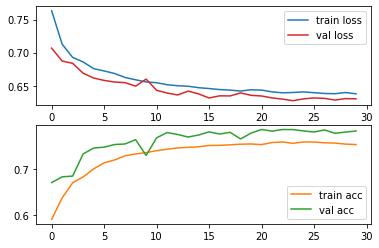

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

# test

In [ ]:
start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.626297652721405
Test accuracy: 0.7835711240768433
time:  0:00:12.068454
